# Transcription Factor Project - Functional Enrichment Analysis
**Robin Anwyl, UCSD Subramaniam Lab**

**Project Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Notebook Description:** 
-  Data: TF KO clusters from minimum distortion embedding (MDE) with DEGs or HVGs as features
-  Analysis: overrepresentation analysis (ORA) using 1) known gene targets of TFs and 2) DEGs of TF KOs in a cluster; pre-ranked gene set enrichment analysis (GSEA) using differential gene expression results for TF KOs in a cluster
***

In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import gseapy as gp
import networkx as nx
import decoupler as dc
#from gprofiler import GProfiler
from tqdm import tqdm

# Pre-ranked GSEA

In [2]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results_gene_symbols.pkl")

In [3]:
de_results.head(3)

DMRT2_baseMean  DMRT2_log2FoldChange  DMRT2_lfcSE  DMRT2_stat  \
A1BG             5.285500              0.609960     0.619478    1.250948   
A2ML1            2.606644              0.100952     0.769812    0.197628   
A2ML1-AS1        8.352237              0.077233     0.476058    0.189240   

           DMRT2_pvalue  DMRT2_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG           0.210953         NaN       3.123957            -0.372431   
A2ML1          0.843336         NaN       1.550960            -0.509398   
A2ML1-AS1      0.849904         NaN       4.474111            -0.086464   

           OSR2_lfcSE  OSR2_stat  ...  ZBED6_lfcSE  ZBED6_stat  ZBED6_pvalue  \
A1BG         0.747259  -0.721735  ...     0.991264   -0.500306      0.616860   
A2ML1        0.982173  -0.941713  ...     1.138998   -0.221171      0.824959   
A2ML1-AS1    0.641921  -0.181294  ...     0.902441   -1.561968      0.118296   

           ZBED6_padj  FAM200B_baseMean  FAM200B_log2FoldChange  \
A1BG              NaN          2.614595               -0.388893   
A2ML1             NaN          2.470636               -0.309124   
A2ML1-AS1         NaN         11.032901                0.407476   

           FAM200B_lfcSE  FAM200B_stat  FAM200B_pvalue  FAM200B_padj  
A1BG            0.816637     -0.736728        0.461288      0.937480  
A2ML1           0.809974     -0.593803        0.552644      0.950115  
A2ML1-AS1       0.450120      1.039717        0.298471      0.916599  

[3 rows x 3912 columns]

In [4]:
clusters_8nbrs = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_4265degs_padj_8nbrs.csv", header=0, index_col=0)
clusters_8nbrs.head()

0        1       2        3        4       5       6       7  \
0      ARX     CBX2     AHR    ATF6B    ASCL1   ATMIN    CDX1   BACH2   
1    ATOH1   CCDC17  ANKZF1   BHLHA9    ETV3L   CENPS    JRKL  CC2D1A   
2  BHLHE41  CREB3L3    ARNT  BHLHA15  FLYWCH1  CHAMP1   PITX2   CEBPB   
3     CREM    DMRT3   ARNT2      ERF    GTF3A  DMRTB1  POU4F3   CEBPD   
4   DMRTC2     ESR1  CAMTA2     FOSB     HMX2   DNMT1  RHOXF2    DLX2   

         8        9  ...     18     19       20       21        22       23  \
0   ARID3A    CEBPA  ...  ESRRG    BSX    ATOH7    CTCFL     AKAP8  FOXD4L5   
1    BARX1  CREB3L4  ...  FOXJ2  DOT1L    DMBX1    DACH2  ARHGAP35     MITF   
2  BHLHE40     ETV1  ...    HDX   HES7  FAM200B    FOXE3     CXXC1    NFXL1   
3    CREB5    FOXS1  ...   IRF9   JUNB    FOXN4  GATAD2A      KLF4     RORC   
4    ESRRA    GATA3  ...  KLF15   MAFK  NEUROD2    GRHL2     KLF10    TBX18   

       24      25     26        27  
0  CREBL2     CRX  ASCL2      EBF2  
1  DMRTA2   GLIS3  CENPX     GMEB2  
2   SMAD4   GTF2I   DLX4  GTF2IRD1  
3   STAT6  TCF7L1  DMRT2     NFKB1  
4  ZNF75D   TIGD2   HSF2    SNAPC4  

[5 rows x 28 columns]

In [45]:
all_libs = gp.get_library_name(organism='Human')
print([lib for lib in all_libs if "GO" in lib])
print([lib for lib in all_libs if "Hallmark" in lib])
print([lib for lib in all_libs if "Reactome" in lib])

['GO_Biological_Process_2021', 'GO_Biological_Process_2023', 'GO_Biological_Process_2025', 'GO_Cellular_Component_2021', 'GO_Cellular_Component_2023', 'GO_Cellular_Component_2025', 'GO_Molecular_Function_2021', 'GO_Molecular_Function_2023', 'GO_Molecular_Function_2025', 'SynGO_2022', 'SynGO_2024']
['MSigDB_Hallmark_2020']
['Reactome_2022', 'Reactome_Pathways_2024']


In [5]:
def rank_clusters(cluster_df, de_df):
    """
    Rank genes of each cluster based on DGE results. For all genes, take mean of
    Wald test statistic ("stat") for that gene for each TF KO in the cluster.
    Return dict of {cluster: DF of ranked genes}.
    """
    all_rank_dfs_dict = dict()
    # Loop through clusters
    for i, cluster in enumerate(cluster_df.columns):
        cluster_de_df_dict = dict()
        cluster_tf_ko_list = cluster_df[cluster][cluster_df[cluster].notna()].tolist()
        for tf_ko in cluster_tf_ko_list:
            # Create DF of DGE results for all TF KOs in cluster
            stat_col = f"{tf_ko}_stat"
            gene_stat_list = de_df[stat_col].tolist()
            cluster_de_df_dict[tf_ko] = gene_stat_list
        # Build DF and calculate mean Wald test statistic
        genes = de_df.index.tolist()
        cluster_de_df = pd.DataFrame(cluster_de_df_dict, index=genes)
        cluster_mean_stat = cluster_de_df.mean(axis=1)
        cluster_mean_stat_df = pd.DataFrame(cluster_mean_stat, 
                                            columns=["Mean Wald test statistic"])
        cluster_mean_stat_df.index.name = "Gene"
        cluster_mean_stat_df.sort_values(by="Mean Wald test statistic", 
                                        ascending=False, inplace=True)
        # Add to dict
        all_rank_dfs_dict[int(i)] = cluster_mean_stat_df
    return all_rank_dfs_dict

def prerank_gsea_cluster(cluster_rank_df, gene_set_lib: str, 
                         min_size=5, max_size=1000, permutation_num=1000,
                         verbose=False):
    """
    Run pre-ranked GSEA on one cluster using the given ranking DataFrame 
    and Enrichr library. min_size and max_size control term size. Return
    gseapy Prerank object.
    """
    prerank_result = gp.prerank(rnk=cluster_rank_df,
                     gene_sets=gene_set_lib,
                     threads=4,
                     min_size=min_size,
                     max_size=max_size,
                     permutation_num=permutation_num, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=verbose,
                    )
    return prerank_result

def prerank_gsea(cluster_df, de_df, gene_set_lib: str, 
                 min_size=5, max_size=1000, permutation_num=1000):
    """
    Run pre-ranked GSEA on all clusters. Return dict {cluster: Prerank object}
    Dependencies: rank_clusters(), prerank_gsea_cluster()
    """
    all_rank_dfs_dict = rank_clusters(cluster_df, de_df)
    prerank_results_dict = dict()
    clusters = list(all_rank_dfs_dict.keys())
    
    for i in tqdm(range(len(clusters)), desc="Processing cluster number"):
        prerank_res = prerank_gsea_cluster(
            all_rank_dfs_dict[clusters[i]], gene_set_lib,
            min_size=min_size, max_size=max_size,
            permutation_num=permutation_num)
        prerank_results_dict[clusters[i]] = prerank_res
    return prerank_results_dict

def build_prerank_gsea_results_df(prerank_results_dict):
    """
    Given a dict of Prerank objects, build combined DF 
    of full preranked GSEA results for all clusters.
    """
    prerank_res_df_list = list()
    for cluster in prerank_results_dict:
        res_df = prerank_results_dict[cluster].res2d
        res_df = res_df.copy()
        res_df.insert(0, "Cluster", [cluster]*res_df.shape[0])
        res_df.drop(columns=["Name"], inplace=True)
        prerank_res_df_list.append(res_df)
    full_prerank_res_df = pd.concat(prerank_res_df_list)
    return full_prerank_res_df

def top_gsea_terms_from_prerank_dict(prerank_results_dict, n_top_terms):
    """
    Given a dict of Prerank objects, build combined DF of top terms per cluster.
    """
    prerank_res_df_list = list()
    for cluster in prerank_results_dict:
        res_df = prerank_results_dict[cluster].res2d
        res_df = res_df.head(n_top_terms).copy()
        res_df.insert(0, "Cluster", [cluster]*res_df.shape[0])
        res_df.drop(columns=["Name"], inplace=True)
        prerank_res_df_list.append(res_df)
    top_prerank_res_df = pd.concat(prerank_res_df_list)
    return top_prerank_res_df

def top_gsea_terms_from_prerank_df(prerank_res_df, n_top_terms):
    """
    Given a DF of prerank results, build combined DF of top terms per cluster. 
    """
    prerank_res_df_list = list()
    clusters = prerank_res_df["Cluster"].unique().tolist()
    for cluster in clusters:
        res_df = prerank_res_df[prerank_res_df["Cluster"] == cluster]
        res_df = res_df.head(n_top_terms).copy()
        prerank_res_df_list.append(res_df)
    top_prerank_res_df = pd.concat(prerank_res_df_list)
    return top_prerank_res_df

In [7]:
def plot_shared_top_terms_prerank_gsea(prerank_res_df, title, xmax=None, min_clusters=1, fig_size=(4,9)):
    """
    Given a DF of prerank results, plot top terms from GSEA 
    shared by multiple clusters.
    """
    if xmax == None:
        xmax = prerank_res_df["Cluster"].nunique() + 1
    up_df = prerank_res_df[prerank_res_df['ES'] > 0]
    down_df = prerank_res_df[prerank_res_df['ES'] < 0]
    up_count_df = pd.DataFrame(up_df['Term'].value_counts())
    up_count_df = up_count_df[up_count_df['count'] >= min_clusters]
    down_count_df = pd.DataFrame(down_df['Term'].value_counts())
    down_count_df = down_count_df[down_count_df['count'] >= min_clusters]
    up_term_list = up_count_df.index.tolist()
    down_term_list = down_count_df.index.tolist()
    term_list = up_term_list + down_term_list
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size)
    sns.barplot(data=up_count_df, x="count", y="Term", orient="h", ax=ax1, color="indianred", height=0.5)
    sns.barplot(data=down_count_df, x="count", y="Term", orient="h", ax=ax2, color="cornflowerblue", height=0.5)
    plt.rcParams.update({"font.size":14})
    for ax in (ax1, ax2):
        ax.set_xlim(0, xmax)
        ax.set_ylabel("")
        ax.set_xlabel("Number of clusters", fontsize=14)
    ax1a = ax1.twinx()
    ax1a.set_ylabel("Upregulated genes", fontsize=14)
    ax2a = ax2.twinx()
    ax2a.set_ylabel("Downregulated genes", fontsize=14)
    for ax in ax1a, ax2a:
        ax.tick_params(axis='y', which='both', right=False)
        ax.set_yticklabels([])
    fig.suptitle(title, fontsize=15, y=0.92)
    return term_list, up_df, down_df


In [6]:
def plot_term_prerank_gsea(prerank_results_dict, cluster_num, term_num, 
                           output_filename=None):
    """
    Built-in gseapy plot for single term in single cluster. 
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    terms = cl_results.res2d.Term
    _ = cl_results.plot(terms=terms[term_num], ofname=output_filename)

def plot_terms_prerank_gsea(prerank_results_dict, cluster_num, n_terms, 
                            title, fig_size=(2,3)):
    """
    Built-in gseapy line plot for n_terms terms in single cluster.
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    terms = cl_results.res2d.Term
    fig = cl_results.plot(terms=terms[:n_terms], show_ranking=True, figsize=fig_size)
    fig.suptitle(title, fontsize=14, y=1.15)
    fig.subplots_adjust(top=0.85, bottom=0.25)
    plt.show()
    
def dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num, title, 
                            dot_size=5, fig_size=(3,4), cutoff=0.25, show_ring=False,
                            output_filename=None):
    """
    Built-in GSEA dotplot for single cluster.
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    ax = gp.dotplot(cl_results.res2d, column="FDR q-val",
                    title=title, cmap=plt.cm.viridis, size=dot_size,
                    figsize=fig_size, cutoff=cutoff, show_ring=show_ring,
                    ofname=output_filename)

### Test code on individual clusters

In [9]:
cl0_rank_df = rank_dict_8nbrs[0]
cl0_rank_df

NameError: name 'rank_dict_8nbrs' is not defined

In [ ]:
cl0_results = prerank_gsea_cluster(cl0_rank_df, "GO_Biological_Process_2025", verbose=True)

2025-06-09 01:55:44,004 [INFO] Parsing data files for GSEA.............................
2025-06-09 01:55:44,753 [INFO] Downloading and generating Enrichr library gene sets......
2025-06-09 01:55:52,200 [INFO] 1097 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-06-09 01:55:52,200 [INFO] 4246 gene_sets used for further statistical testing.....
2025-06-09 01:55:52,201 [INFO] Start to run GSEA...Might take a while..................
2025-06-09 01:57:08,399 [INFO] Congratulations. GSEApy runs successfully................



In [40]:
cl0_max500_results = prerank_gsea_cluster(
    cl0_rank_df, "GO_Biological_Process_2025", verbose=True, max_size=500)

2025-06-09 02:12:09,389 [INFO] Parsing data files for GSEA.............................
2025-06-09 02:12:09,407 [INFO] Enrichr library gene sets already downloaded in: /home/ranwyl/.cache/gseapy, use local file
2025-06-09 02:12:09,470 [INFO] 1101 gene_sets have been filtered out when max_size=500 and min_size=5
2025-06-09 02:12:09,470 [INFO] 4242 gene_sets used for further statistical testing.....
2025-06-09 02:12:09,471 [INFO] Start to run GSEA...Might take a while..................
2025-06-09 02:13:25,327 [INFO] Congratulations. GSEApy runs successfully................



In [25]:
cl1_rank_df = rank_dict_8nbrs[1]
cl1_results = prerank_gsea_cluster(cl1_rank_df, "GO_Biological_Process_2025", verbose=True)

2025-06-09 02:00:55,744 [INFO] Parsing data files for GSEA.............................
2025-06-09 02:00:55,762 [INFO] Enrichr library gene sets already downloaded in: /home/ranwyl/.cache/gseapy, use local file
2025-06-09 02:00:55,826 [INFO] 1097 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-06-09 02:00:55,826 [INFO] 4246 gene_sets used for further statistical testing.....
2025-06-09 02:00:55,827 [INFO] Start to run GSEA...Might take a while..................
2025-06-09 02:02:12,498 [INFO] Congratulations. GSEApy runs successfully................



In [49]:
cl2_rank_df = rank_dict_8nbrs[2]
cl2_results = prerank_gsea_cluster(cl2_rank_df, "GO_Biological_Process_2025", verbose=True)

2025-06-09 02:20:51,774 [INFO] Parsing data files for GSEA.............................
2025-06-09 02:20:51,791 [INFO] Enrichr library gene sets already downloaded in: /home/ranwyl/.cache/gseapy, use local file
2025-06-09 02:20:51,858 [INFO] 1097 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-06-09 02:20:51,859 [INFO] 4246 gene_sets used for further statistical testing.....
2025-06-09 02:20:51,859 [INFO] Start to run GSEA...Might take a while..................
2025-06-09 02:22:10,065 [INFO] Congratulations. GSEApy runs successfully................



GOBP, cluster 0, term size < 1000

In [42]:
cl0_results.res2d.head()

Name                                               Term        ES  \
0  prerank               Cytoplasmic Translation (GO:0002181) -0.934657   
1  prerank    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2  prerank                           Translation (GO:0006412) -0.817965   
3  prerank                       Gene Expression (GO:0010467) -0.741987   
4  prerank  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

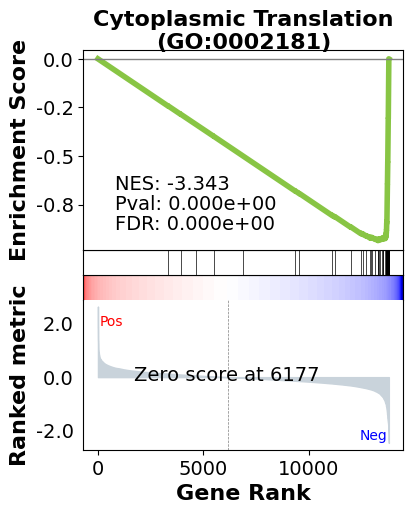

In [44]:
terms = cl0_results.res2d.Term
axs = cl0_results.plot(terms=terms[0])

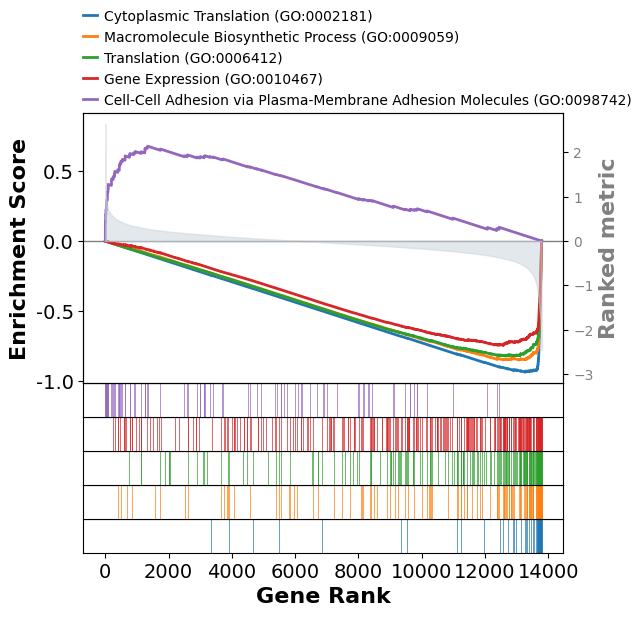

In [ ]:
axs = cl0_results.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

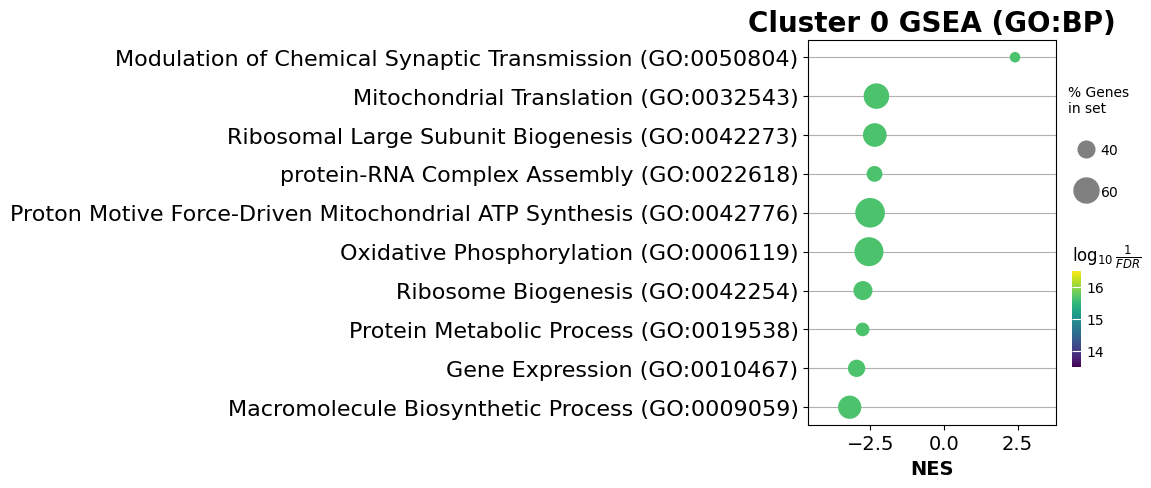

In [48]:
ax = gp.dotplot(cl0_results.res2d,
             column="FDR q-val",
             title='Cluster 0 GSEA (GO:BP)',
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

GOBP, cluster 0, term size < 500

In [43]:
cl0_max500_results.res2d.head()

Name                                               Term        ES  \
0  prerank               Cytoplasmic Translation (GO:0002181) -0.934657   
1  prerank    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2  prerank                           Translation (GO:0006412) -0.817965   
3  prerank                       Gene Expression (GO:0010467) -0.741987   
4  prerank  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

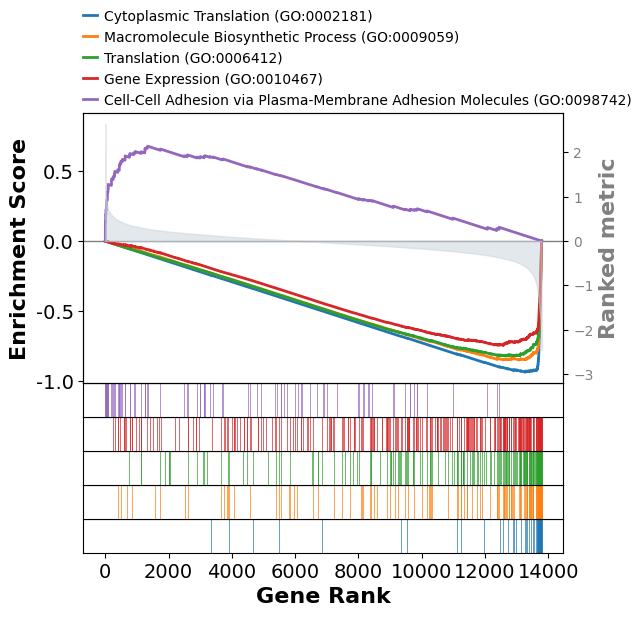

In [45]:
axs = cl0_max500_results.plot(terms=terms[0:5],
                   show_ranking=True,
                   figsize=(3,4)
                  )

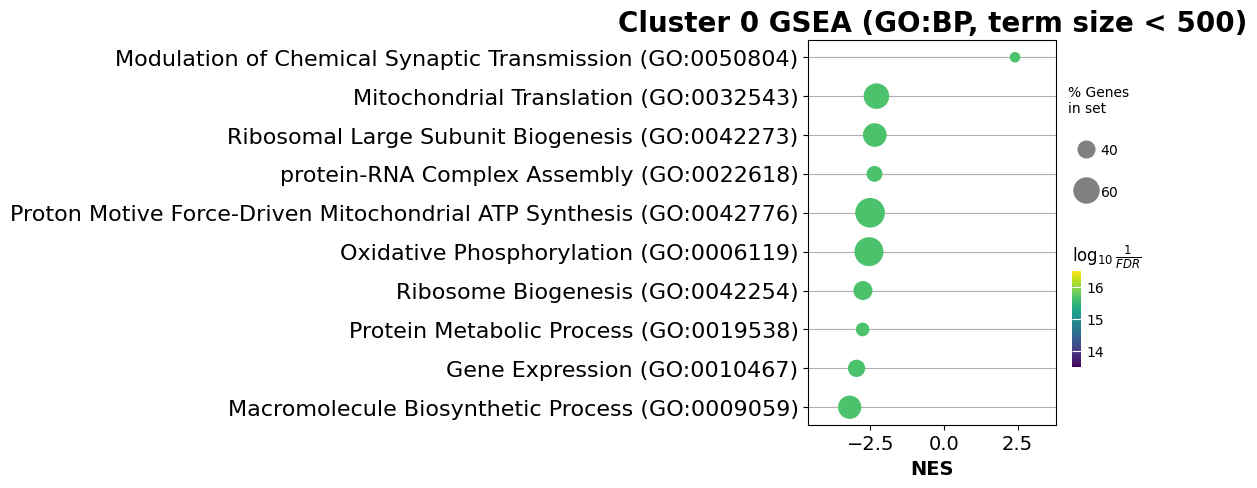

In [47]:
ax = gp.dotplot(cl0_max500_results.res2d,
             column="FDR q-val",
             title='Cluster 0 GSEA (GO:BP, term size < 500)',
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

GOBP, cluster 1, term size < 1000

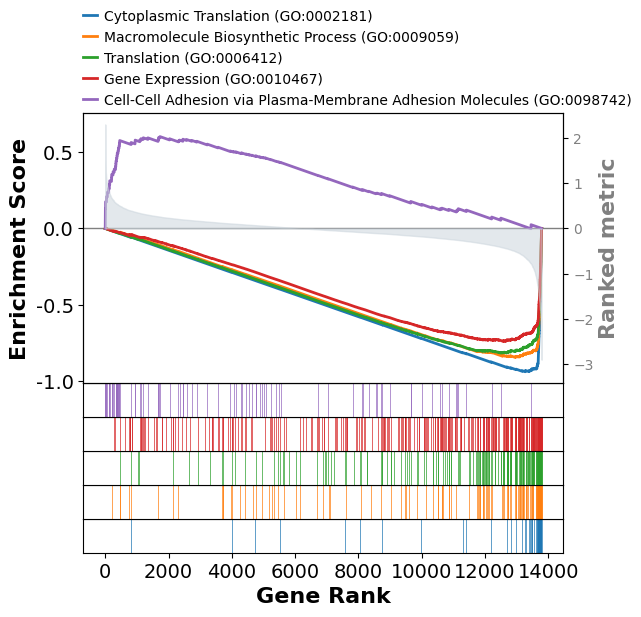

In [32]:
axs = cl1_results.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

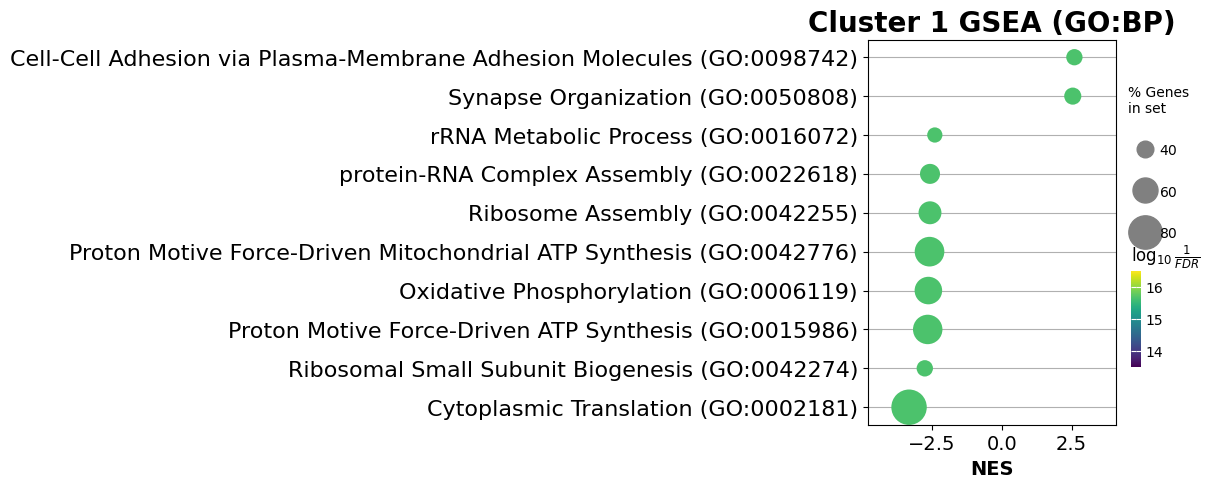

In [46]:
ax = gp.dotplot(cl1_results.res2d,
             column="FDR q-val",
             title='Cluster 1 GSEA (GO:BP)',
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

GOBP, cluster 2, term size < 1000

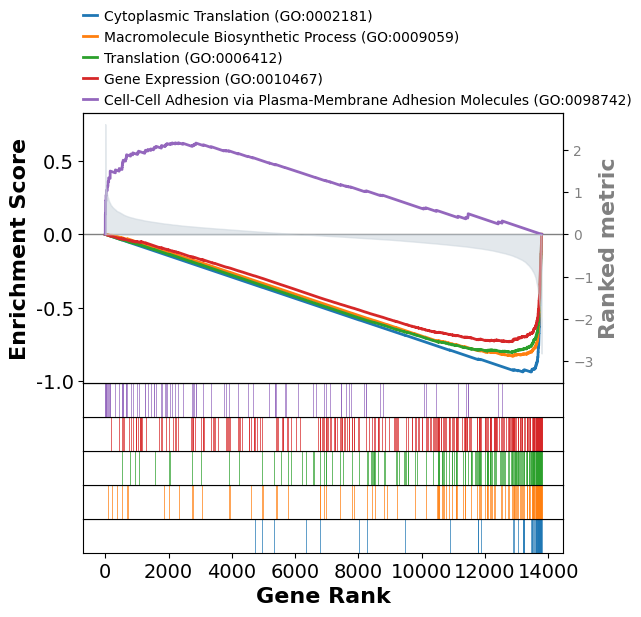

In [50]:
axs = cl2_results.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

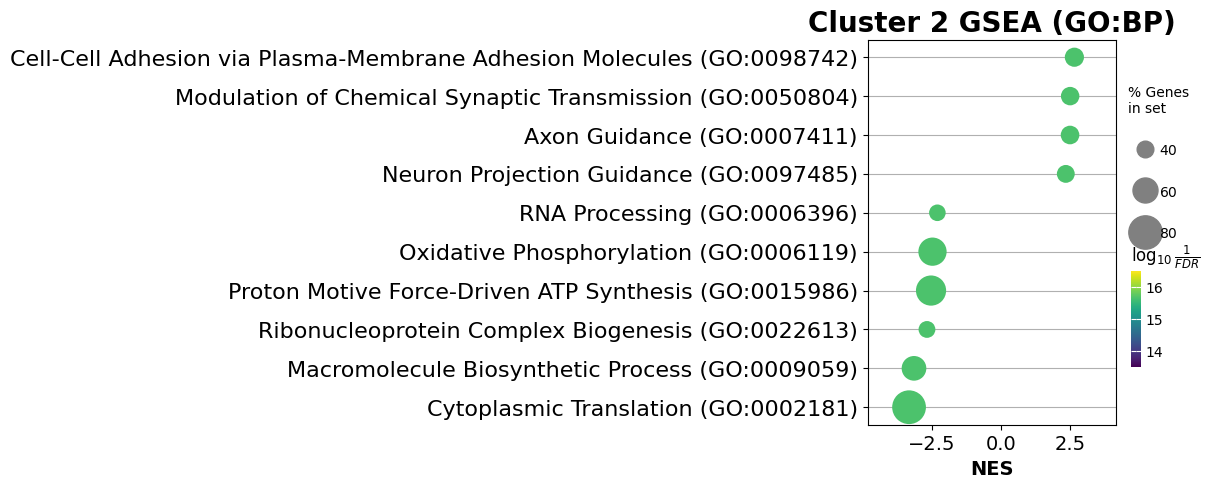

In [51]:
ax = gp.dotplot(cl2_results.res2d,
             column="FDR q-val",
             title='Cluster 2 GSEA (GO:BP)',
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

### GO

In [13]:
prerank_res_gobp8 = prerank_gsea(clusters_8nbrs, de_results, "GO_Biological_Process_2025")

Processing cluster number: 100%|██████████| 29/29 [37:59<00:00, 78.61s/it]


Prerank GSEA took 38 minutes

In [ ]:
prerank_res_df_gobp8 = build_prerank_gsea_results_df(prerank_res_gobp8)

In [155]:
prerank_res_df_gobp8.head(3)

Cluster                                             Term        ES  \
0        0             Cytoplasmic Translation (GO:0002181) -0.934657   
1        0  Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2        0                         Translation (GO:0006412) -0.817965   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...

In [197]:
prerank_res_df_gobp_fdr8 = prerank_res_df_gobp8[(prerank_res_df_gobp8["FDR q-val"] < 0.05)].copy()
prerank_res_df_gobp_fdr8.head()

Cluster                                               Term        ES  \
0        0               Cytoplasmic Translation (GO:0002181) -0.934657   
1        0    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2        0                           Translation (GO:0006412) -0.817965   
3        0                       Gene Expression (GO:0010467) -0.741987   
4        0  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

In [150]:
prerank_res_df_gobp8.shape

(123134, 10)

In [156]:
# Save
prerank_res_df_gobp8.to_pickle("/home/ranwyl/results_tf_project/gsea_gobp_8nbrs.pkl")

In [8]:
prerank_res_df_gobp8 = pd.read_pickle("/home/ranwyl/results_tf_project/gsea_gobp_8nbrs.pkl")
prerank_res_df_gobp8.head()

Cluster                                               Term        ES  \
0        0               Cytoplasmic Translation (GO:0002181) -0.934657   
1        0    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2        0                           Translation (GO:0006412) -0.817965   
3        0                       Gene Expression (GO:0010467) -0.741987   
4        0  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

In [143]:
prerank_res_gobp8[0].res2d.shape

(4246, 10)

In [146]:
prerank_res_gobp8[0].res2d.head()

Name                                               Term        ES  \
0  prerank               Cytoplasmic Translation (GO:0002181) -0.934657   
1  prerank    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2  prerank                           Translation (GO:0006412) -0.817965   
3  prerank                       Gene Expression (GO:0010467) -0.741987   
4  prerank  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

In [ ]:
top_term_gobp8 = top_gsea_terms_from_prerank_dict(prerank_res_gobp8, n_top_terms=1)

In [22]:
top_term_gobp8.head()

Cluster                                  Term        ES       NES  \
0        0  Cytoplasmic Translation (GO:0002181) -0.934657 -3.343449   
0        1  Cytoplasmic Translation (GO:0002181)  -0.94114  -3.31936   
0        2  Cytoplasmic Translation (GO:0002181)  -0.93908 -3.330925   
0        3  Cytoplasmic Translation (GO:0002181) -0.934458 -3.348201   
0        4  Cytoplasmic Translation (GO:0002181) -0.935749 -3.408179   

  NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0       0.0       0.0        0.0  83/100  3.74%   
0       0.0       0.0        0.0  85/100  3.76%   
0       0.0       0.0        0.0  81/100  2.41%   
0       0.0       0.0        0.0  80/100  1.94%   
0       0.0       0.0        0.0  80/100  2.39%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
0  RPLP1;RPS18;RPS14;RPS28;RPL23;RPS8;RPL41;RPS2;...  
0  RPLP1;RPS12;RPL39;RPS6;RPS2;RPS23;RPS8;RPS3A;R...  
0  RPLP1;RPS28;RPS12;RPS8;RPS15A;RPL39;RPL35A;RPS...  
0  RPLP1;RPS8;RPL39;RPS28;RPL8;RPS23;RPL30;RPS3;R...

In [ ]:
top_5_terms_gobp8 = top_gsea_terms_from_prerank_dict(prerank_res_gobp8, n_top_terms=5)

In [7]:
# top_5_terms_gobp8.head(50)

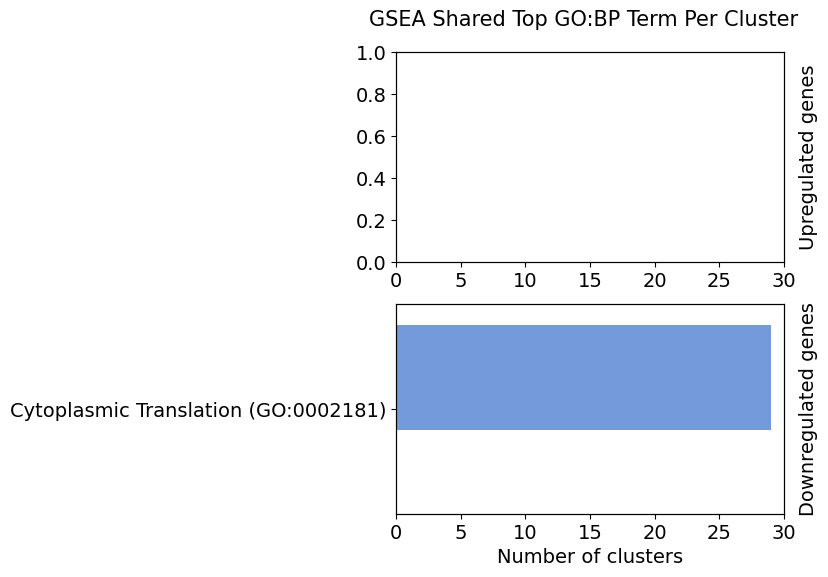

In [49]:
_ = plot_shared_top_terms_prerank_gsea(top_term_gobp8, "GSEA Shared Top GO:BP Term Per Cluster")

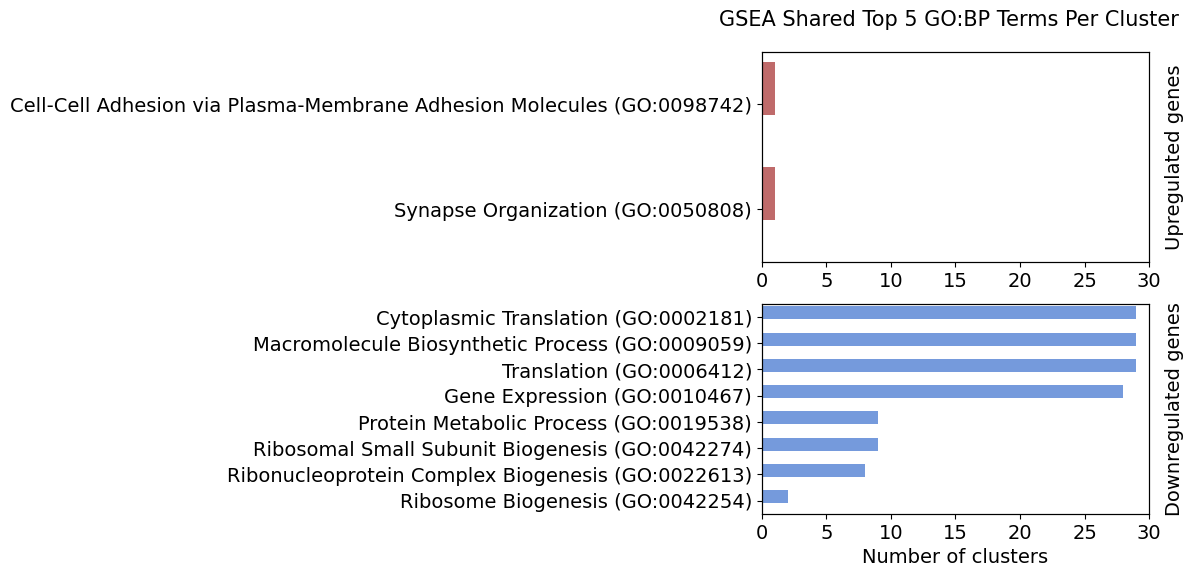

In [53]:
up_terms_gobp8, down_terms_gobp8 = \
    plot_shared_top_terms_prerank_gsea(top_5_terms_gobp8, "GSEA Shared Top 5 GO:BP Terms Per Cluster")

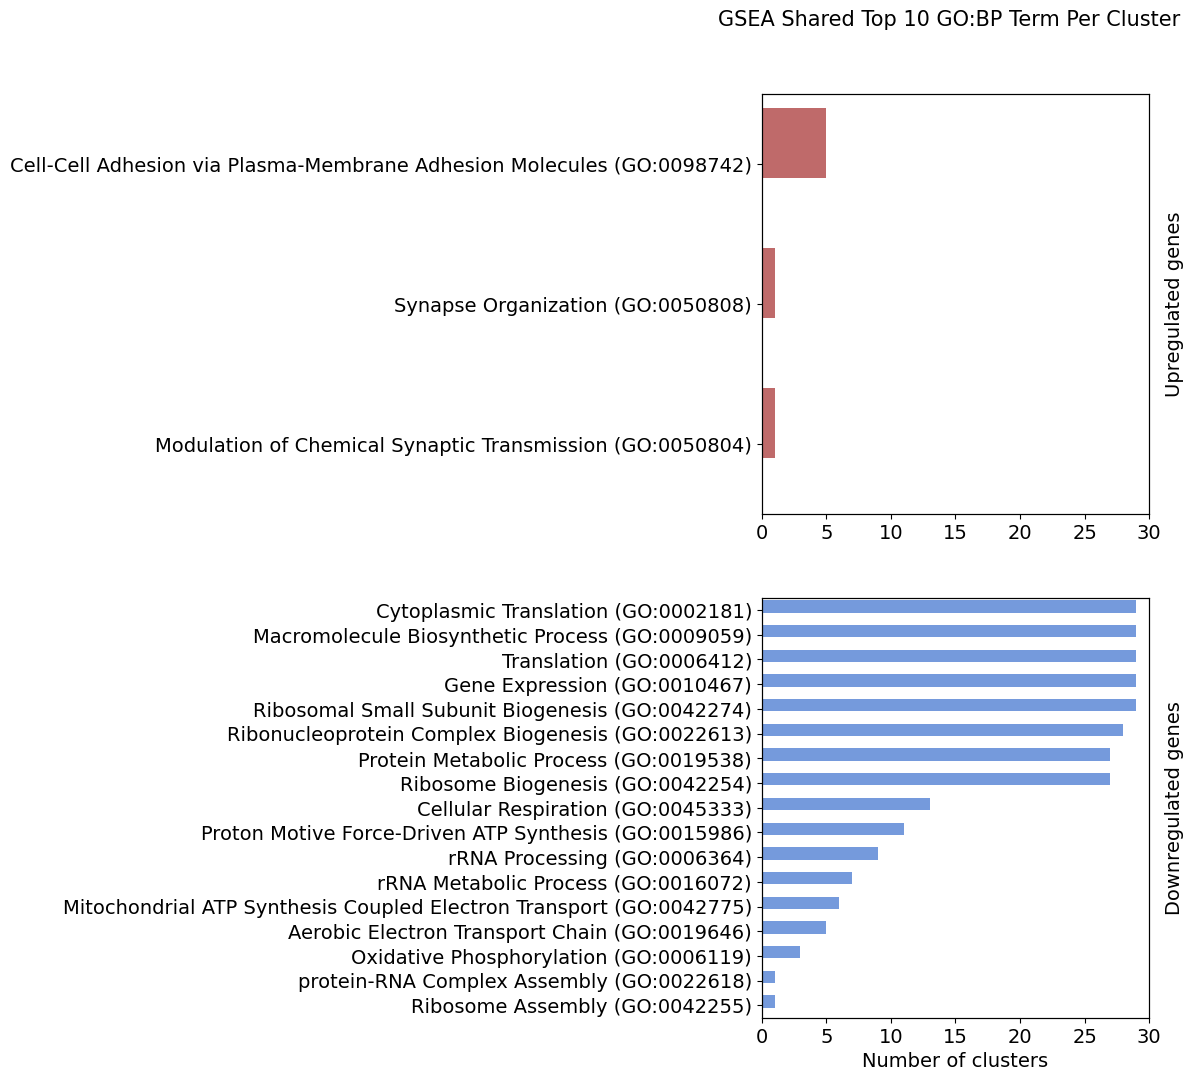

In [11]:
top_10_terms_gobp8 = top_gsea_terms_from_prerank_df(prerank_res_df_gobp8, 10)
_ = plot_shared_top_terms_prerank_gsea(top_10_terms_gobp8, "GSEA Shared Top 10 GO:BP Term Per Cluster", fig_size=(5,12))

In [56]:
up_terms_gobp8

Cluster                                               Term        ES  \
4        0  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   
4        2                  Synapse Organization (GO:0050808)  0.618489   

        NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
4  2.875446       0.0       0.0        0.0  33/87   9.73%   
4  2.761105       0.0       0.0        0.0  48/95  18.04%   

                                          Lead_genes  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...  
4  SYN3;NRXN1;ADGRL3;ANK3;NLGN1;PDZRN3;PTPRD;CDH2...

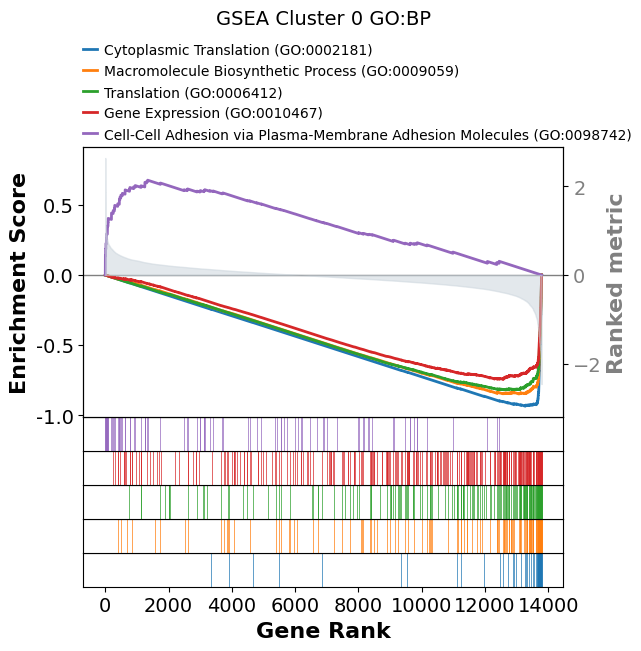

In [117]:
plot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=0, n_terms=5, title="GSEA Cluster 0 GO:BP")

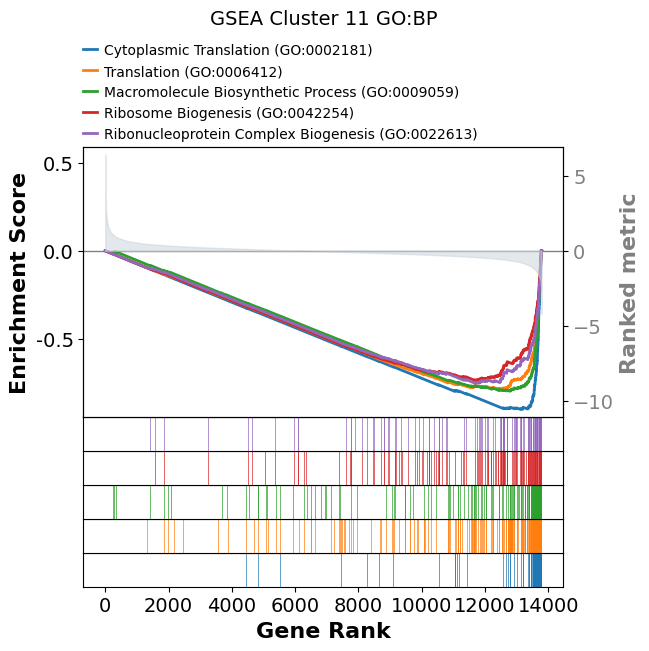

In [118]:
plot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=11, n_terms=5, title="GSEA Cluster 11 GO:BP")

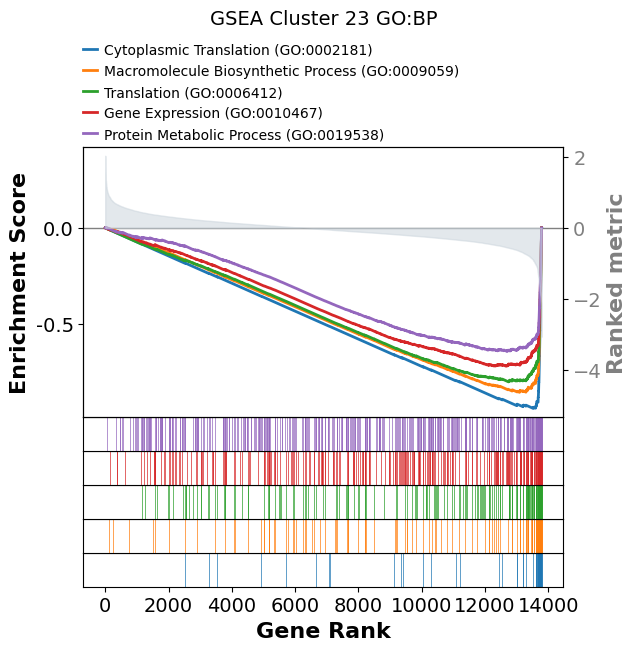

In [119]:
plot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=23, n_terms=5, title="GSEA Cluster 23 GO:BP")

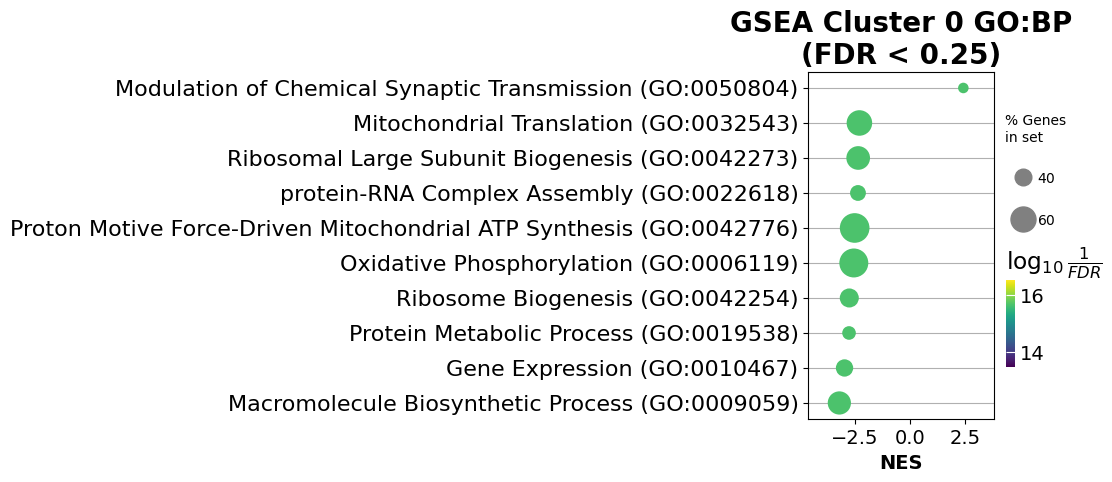

In [167]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=0, 
                           title="GSEA Cluster 0 GO:BP\n(FDR < 0.25)", fig_size=(3, 4.5))

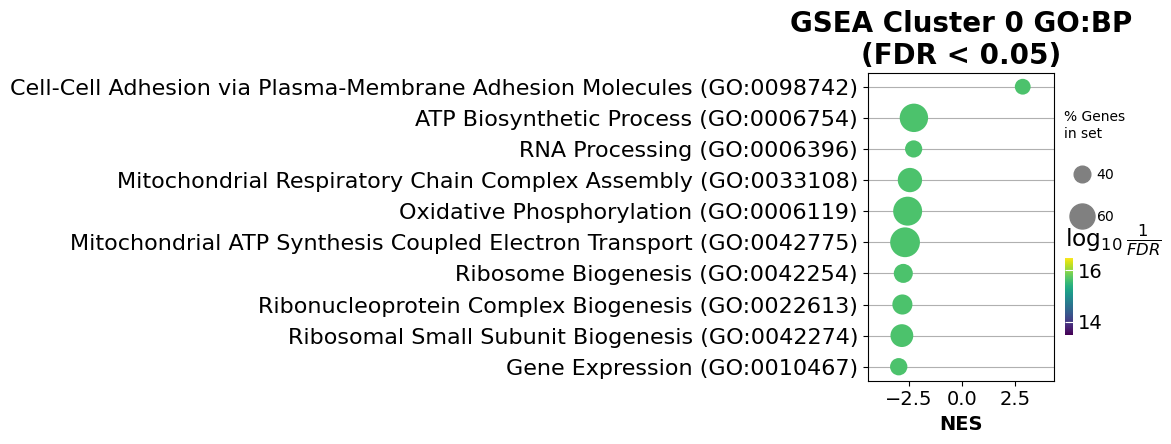

In [175]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=0, 
                           title="GSEA Cluster 0 GO:BP\n(FDR < 0.05)", cutoff=0.05)

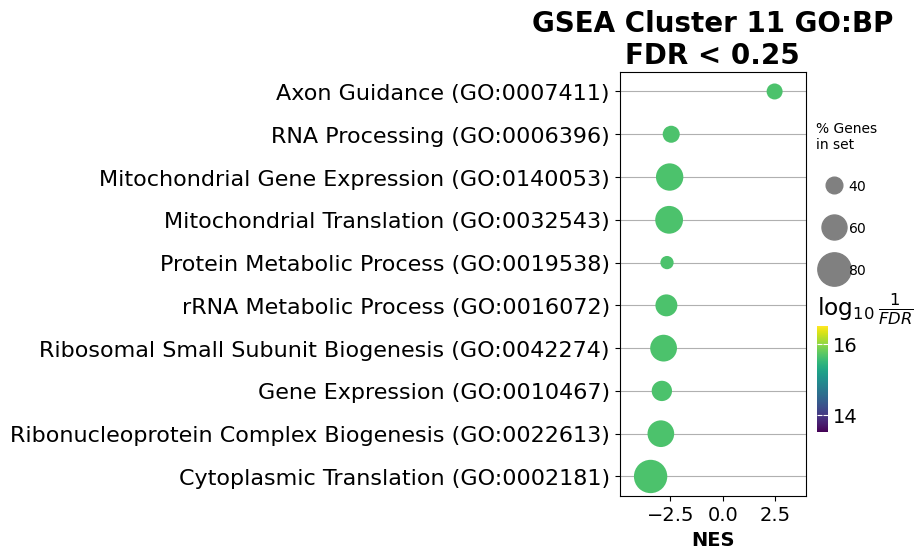

In [181]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=11, 
                           title="GSEA Cluster 11 GO:BP\nFDR < 0.25", fig_size=(3,5.5))

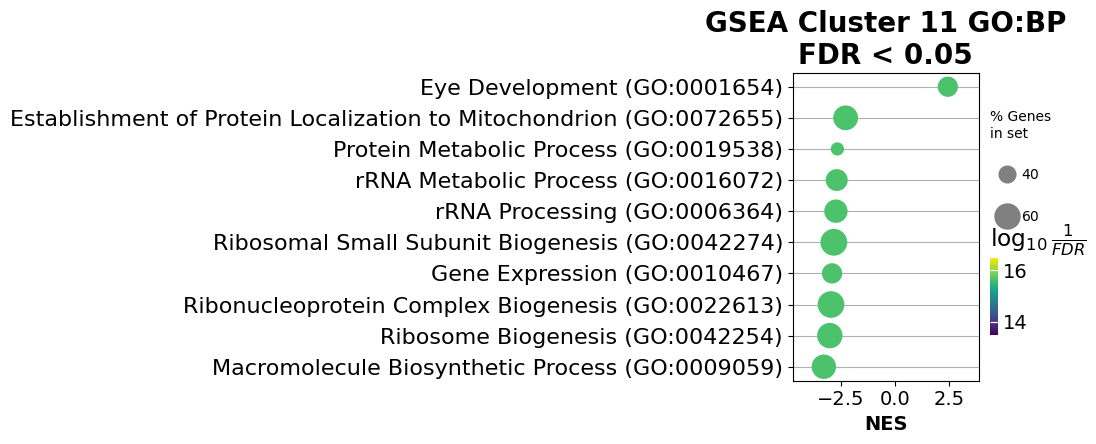

In [180]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=11, 
                           title="GSEA Cluster 11 GO:BP\nFDR < 0.05", fig_size=(3,4), cutoff=0.05)

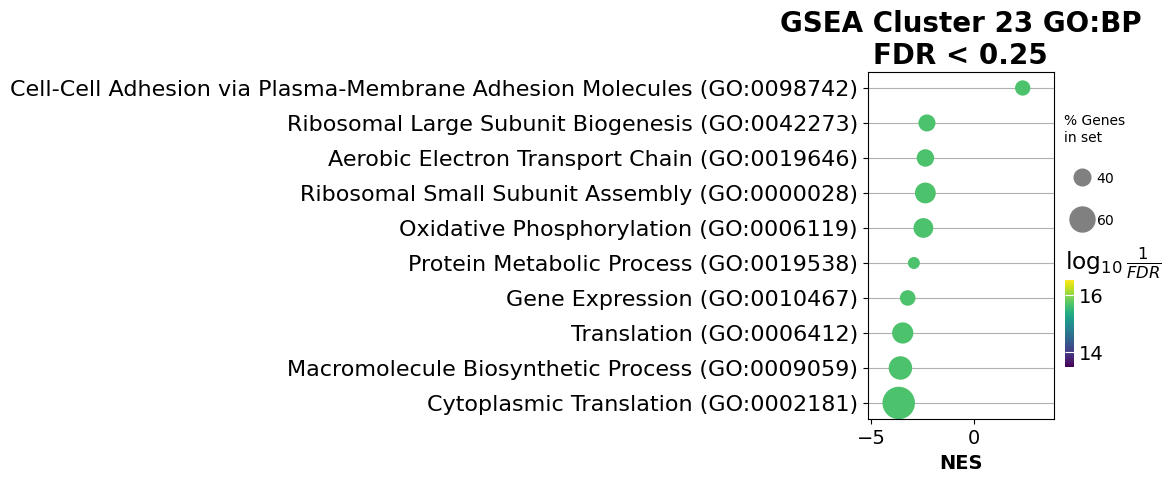

In [186]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=23, 
                           title="GSEA Cluster 23 GO:BP\nFDR < 0.25", fig_size=(3,4.5))

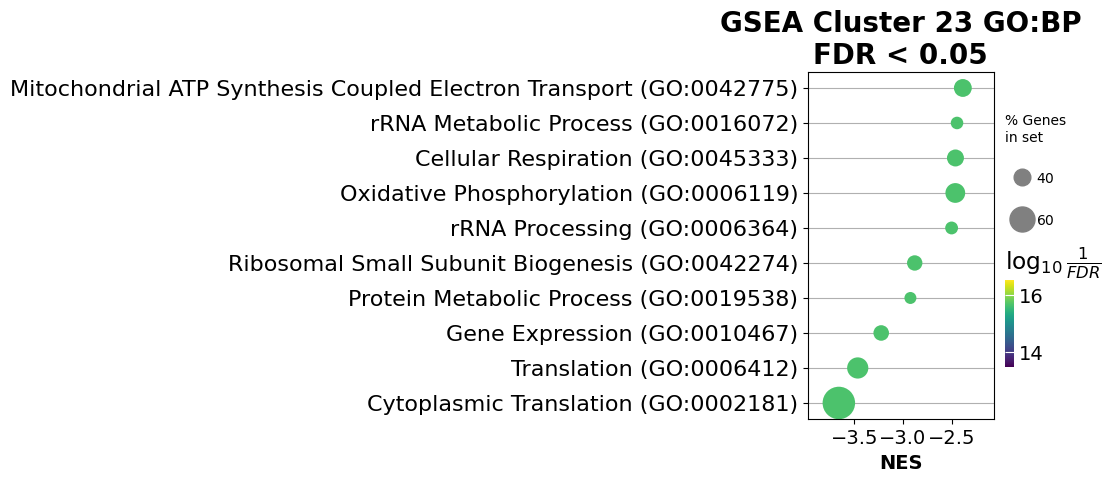

In [185]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=23, 
                           title="GSEA Cluster 23 GO:BP\nFDR < 0.05", 
                           fig_size=(3,4.5), cutoff=0.05)

Save all GO:BP dotplots with FDR < 0.05

In [194]:
def plot_all_dotplots(prerank_results_dict, gene_set_lib, folder, gene_set_lib_abbrev):
    for cluster in prerank_results_dict.keys():
        title=f"GSEA Cluster {cluster} {gene_set_lib}\n(FDR < 0.05)"
        output_file_name = f"{folder}/gseapy_dotplot_{gene_set_lib_abbrev}_CL{cluster}.png"
        dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num=cluster,
                                   title=title, fig_size=(3,6), cutoff=0.05, 
                                   output_filename=output_file_name)

In [195]:
gseapy_gobp_folder = "/home/ranwyl/results_tf_project/gseapy_gobp_figs"
plot_all_dotplots(prerank_res_gobp8, "GO:BP", gseapy_gobp_folder, "gobp")

In [ ]:
prerank_res_reac8 = prerank_gsea(clusters_8nbrs, de_results, "Reactome_Pathways_2024")

Processing cluster number: 100%|██████████| 29/29 [15:21<00:00, 31.76s/it]


In [ ]:
prerank_res_df_reac8 = build_prerank_gsea_results_df(prerank_res_reac)

In [ ]:
prerank_res_df_reac8.head(3)

In [ ]:
prerank_res_df_reac_fdr8 = prerank_res_df_reac8[(prerank_res_df_reac8["FDR q-val"] < 0.05)].copy()
prerank_res_df_reac_fdr8.head()

In [ ]:
prerank_res_df_reac8.shape

In [ ]:
# Save
prerank_res_df_reac8.to_pickle("/home/ranwyl/results_tf_project/gsea_reac_8nbrs.pkl")

In [ ]:
prerank_res_reac8[0].res2d.shape

(4246, 10)

In [ ]:
prerank_res_reac8[0].res2d.head()

In [ ]:
top_term_reac8 = top_gsea_terms_from_prerank_dict(prerank_res_reac8, n_top_terms=1)

In [ ]:
top_term_reac8.head()

In [ ]:
top_5_terms_reac8 = top_gsea_terms_from_prerank_dict(prerank_res_reac8, n_top_terms=5)

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_term_reac8, "GSEA Shared Top Reactome Term Per Cluster")

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_5_terms_reac8, "GSEA Shared Top 5 Reactome Terms Per Cluster")

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, n_terms=5, title="GSEA Cluster 0 Reactome")

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, n_terms=5, title="GSEA Cluster 11 Reactome")

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, n_terms=5, title="GSEA Cluster 23 Reactome")

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, 
                           title="GSEA Cluster 0 Reactome\n(FDR < 0.25)", fig_size=(3, 4.5))

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, 
                           title="GSEA Cluster 0 Reactome\n(FDR < 0.05)", cutoff=0.05)

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, 
                           title="GSEA Cluster 11 Reactome\n(FDR < 0.25)", fig_size=(3, 4.5))

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, 
                           title="GSEA Cluster 11 Reactome\n(FDR < 0.05)", cutoff=0.05)

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, 
                           title="GSEA Cluster 23 Reactome\n(FDR < 0.25)", fig_size=(3, 4.5))

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, 
                           title="GSEA Cluster 23 Reactome\n(FDR < 0.05)", cutoff=0.05)

Save all GO:BP dotplots with FDR < 0.05

In [ ]:
def plot_all_dotplots(prerank_results_dict, gene_set_lib, folder, gene_set_lib_abbrev):
    for cluster in prerank_results_dict.keys():
        title=f"GSEA Cluster {cluster} {gene_set_lib}\n(FDR < 0.05)"
        output_file_name = f"{folder}/gseapy_dotplot_{gene_set_lib_abbrev}_CL{cluster}.png"
        dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num=cluster,
                                   title=title, fig_size=(3,6), cutoff=0.05, 
                                   output_filename=output_file_name)

In [ ]:
gseapy_gobp_folder = "/home/ranwyl/results_tf_project/gseapy_reac_figs"
plot_all_dotplots(prerank_res_reac8, "Reactome", gseapy_gobp_folder, "reac")

### Reactome

In [ ]:
prerank_res_reac8 = prerank_gsea(clusters_8nbrs, de_results, "Reactome_Pathways_2024")

Processing cluster number: 100%|██████████| 29/29 [15:21<00:00, 31.76s/it]


In [ ]:
prerank_res_df_reac8 = build_prerank_gsea_results_df(prerank_res_reac8)

In [ ]:
prerank_res_df_reac8.head(3)

Cluster                                               Term        ES  \
0        0  Response of EIF2AK4 (GCN2) to Amino Acid Defic... -0.955738   
1        0  L13a-mediated Translational Silencing of Cerul... -0.932755   
2        0           Formation of a Pool of Free 40S Subunits -0.945244   

        NES NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0 -3.394836       0.0       0.0        0.0   82/97  2.38%   
1 -3.383922       0.0       0.0        0.0  91/109  3.74%   
2 -3.374474       0.0       0.0        0.0   88/99  3.74%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
2  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...

In [ ]:
prerank_res_df_reac_fdr8 = prerank_res_df_reac8[(prerank_res_df_reac8["FDR q-val"] < 0.05)].copy()
prerank_res_df_reac_fdr8.head()

Cluster                                               Term        ES  \
0        0  Response of EIF2AK4 (GCN2) to Amino Acid Defic... -0.955738   
1        0  L13a-mediated Translational Silencing of Cerul... -0.932755   
2        0           Formation of a Pool of Free 40S Subunits -0.945244   
3        0                        Selenoamino Acid Metabolism -0.940342   
4        0                  Eukaryotic Translation Elongation -0.965283   

        NES NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0 -3.394836       0.0       0.0        0.0   82/97  2.38%   
1 -3.383922       0.0       0.0        0.0  91/109  3.74%   
2 -3.374474       0.0       0.0        0.0   88/99  3.74%   
3 -3.373223       0.0       0.0        0.0  82/111  2.38%   
4 -3.372793       0.0       0.0        0.0   85/91  2.53%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
2  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
3  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
4  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...

In [ ]:
prerank_res_df_reac8.shape

(51823, 10)

In [ ]:
# Save
prerank_res_df_reac8.to_pickle("/home/ranwyl/results_tf_project/gsea_reac_8nbrs.pkl")

In [ ]:
top_term_reac8 = top_gsea_terms_from_prerank_dict(prerank_res_reac8, n_top_terms=1)

In [ ]:
top_term_reac8.head()

Cluster                                               Term        ES  \
0        0  Response of EIF2AK4 (GCN2) to Amino Acid Defic... -0.955738   
0        1                           Selenocysteine Synthesis -0.967883   
0        2  SRP-dependent Cotranslational Protein Targetin... -0.941989   
0        3                           Selenocysteine Synthesis -0.967243   
0        4                           Selenocysteine Synthesis -0.970968   

        NES NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0 -3.394836       0.0       0.0        0.0   82/97  2.38%   
0 -3.379185       0.0       0.0        0.0   79/91  1.26%   
0 -3.424396       0.0       0.0        0.0  92/110  2.70%   
0 -3.456918       0.0       0.0        0.0   80/91  1.49%   
0 -3.465451       0.0       0.0        0.0   81/91  1.72%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
0  RPLP1;RPS18;RPS14;RPS28;RPL23;RPS8;RPL41;RPS2;...  
0  RPLP1;RPS12;RPL39;RPS6;RPS2;RPS23;RPS8;RPS3A;R...  
0  RPLP1;RPS28;RPS12;RPS8;RPS15A;RPL39;RPL35A;RPS...  
0  RPLP1;RPS8;RPL39;RPS28;RPL8;RPS23;RPL30;RPS3;R...

In [ ]:
top_5_terms_reac8 = top_gsea_terms_from_prerank_dict(prerank_res_reac8, n_top_terms=5)

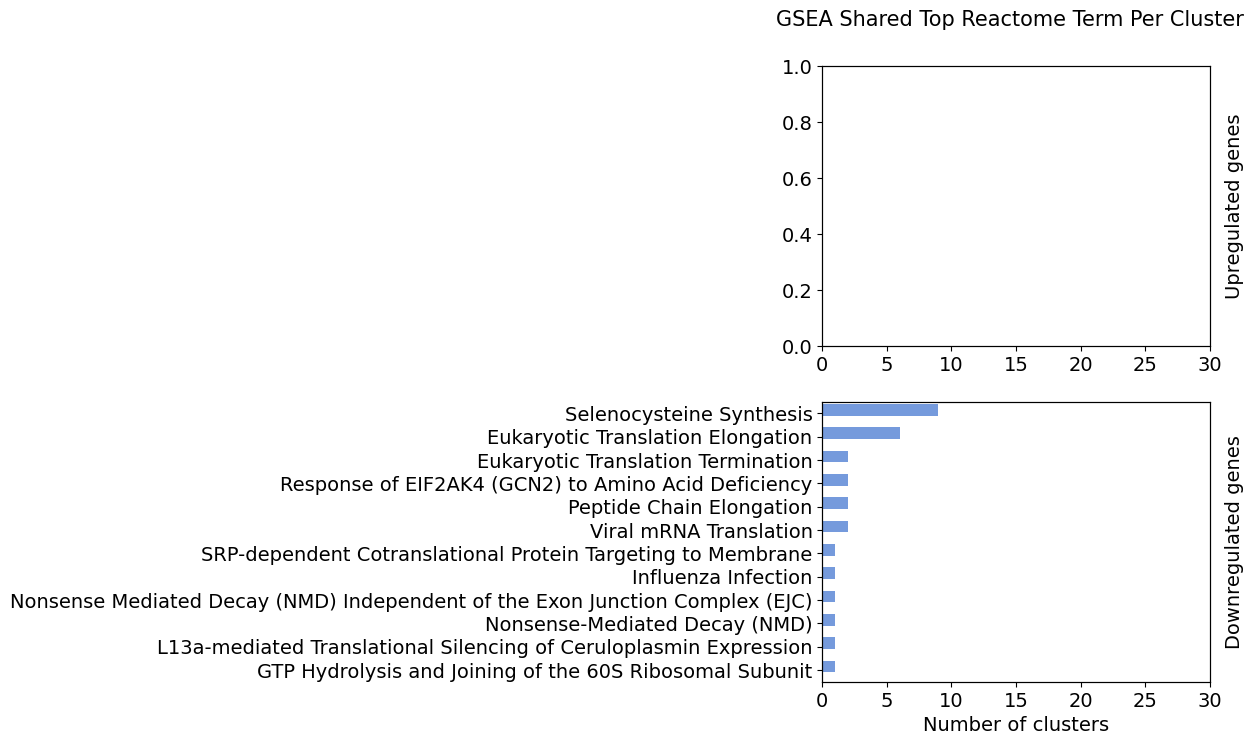

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_term_reac8, 
"GSEA Shared Top Reactome Term Per Cluster", fig_size=(5,8))

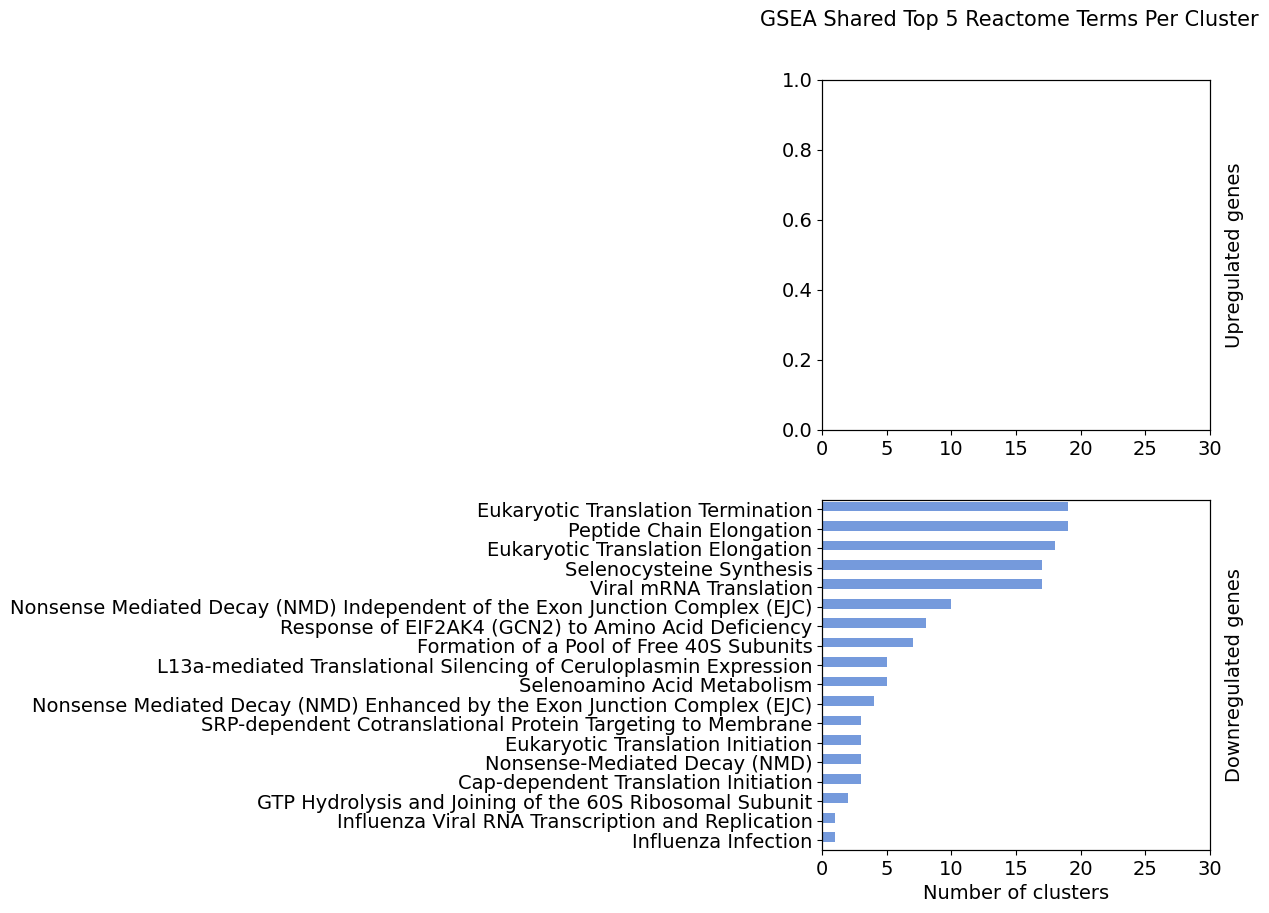

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_5_terms_reac8, 
"GSEA Shared Top 5 Reactome Terms Per Cluster", fig_size=(5,10))

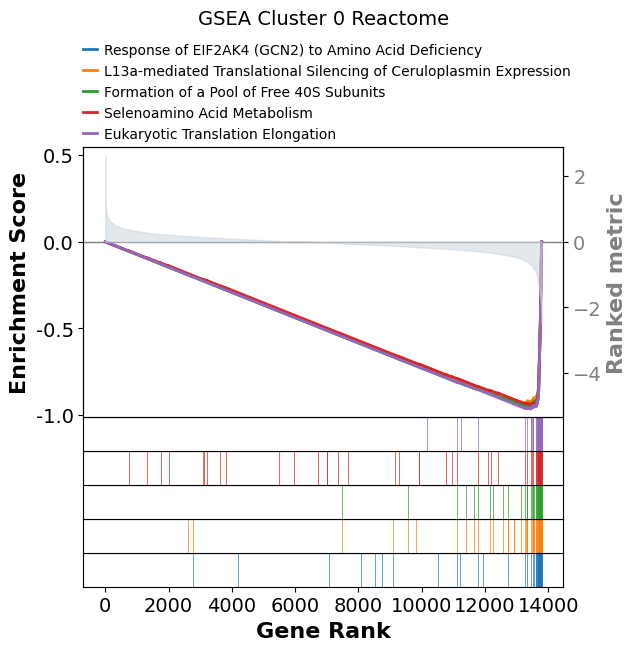

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, n_terms=5, title="GSEA Cluster 0 Reactome")

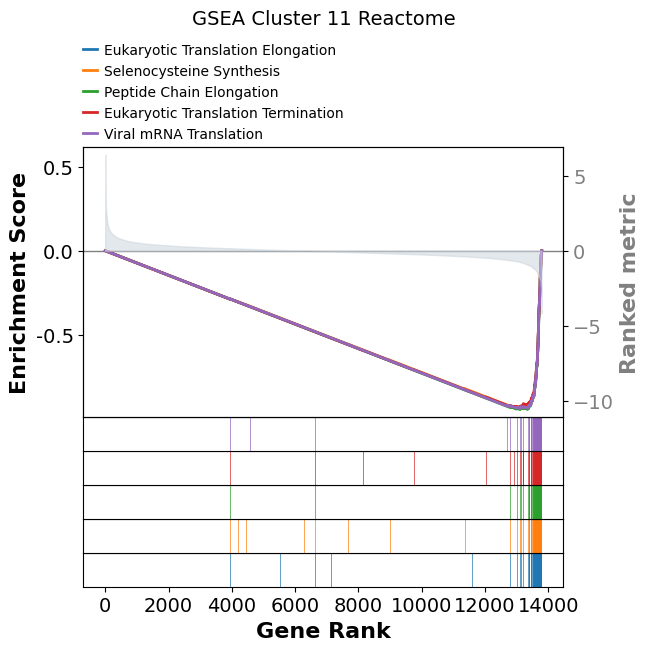

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, n_terms=5, title="GSEA Cluster 11 Reactome")

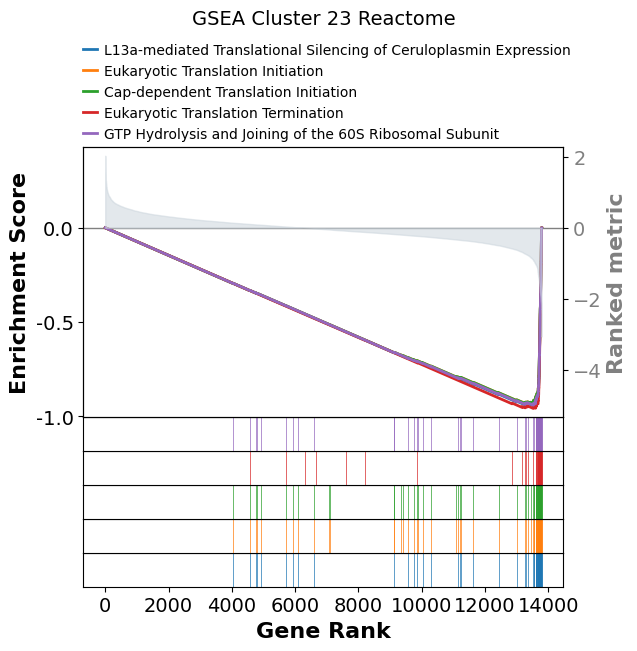

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, n_terms=5, title="GSEA Cluster 23 Reactome")

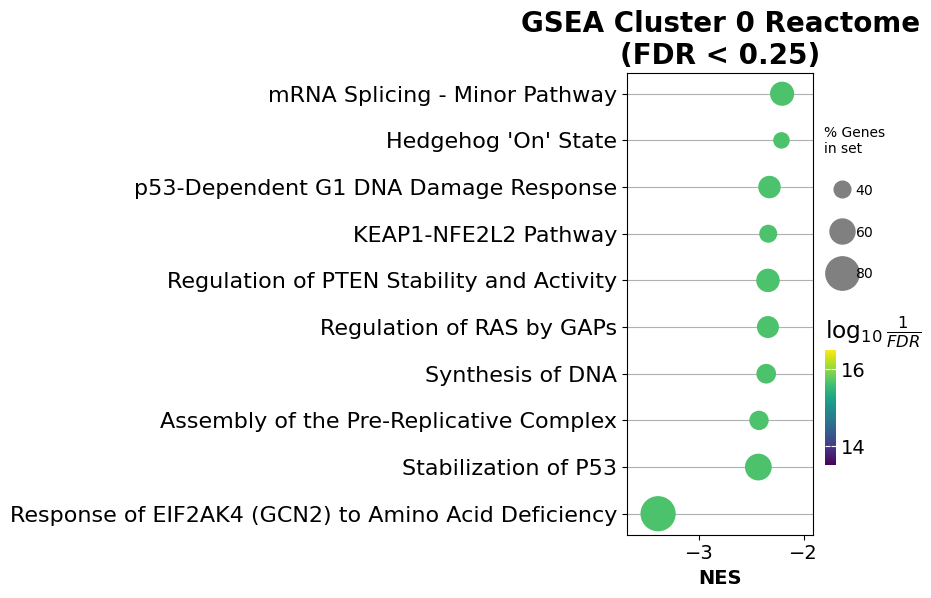

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, 
                           title="GSEA Cluster 0 Reactome\n(FDR < 0.25)", fig_size=(3,6))

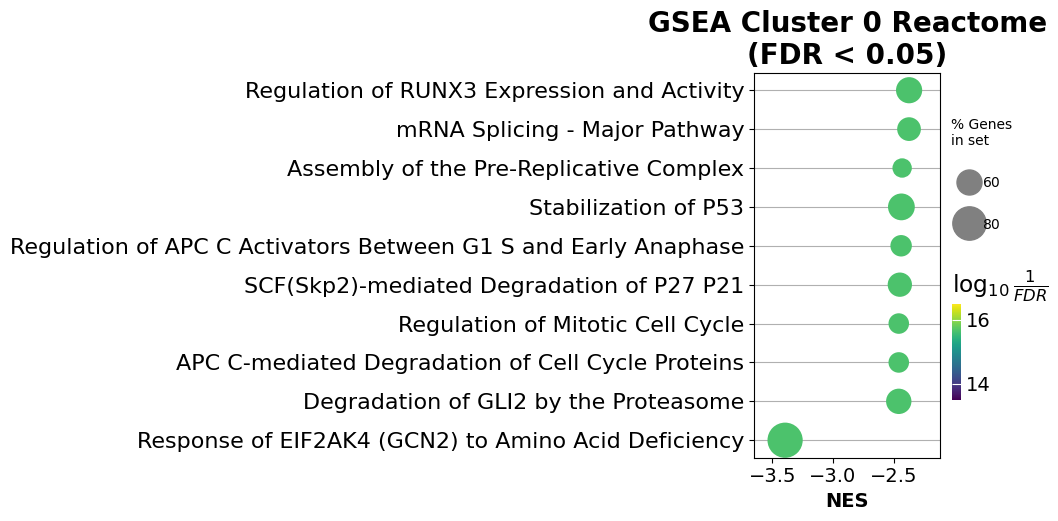

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, 
                           title="GSEA Cluster 0 Reactome\n(FDR < 0.05)", cutoff=0.05, fig_size=(3,5))

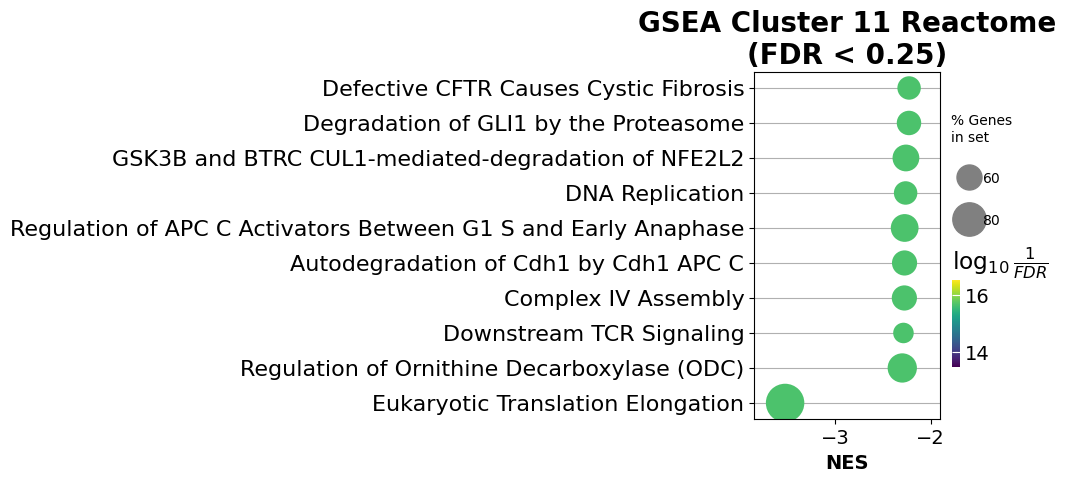

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, 
                           title="GSEA Cluster 11 Reactome\n(FDR < 0.25)", fig_size=(3, 4.5))

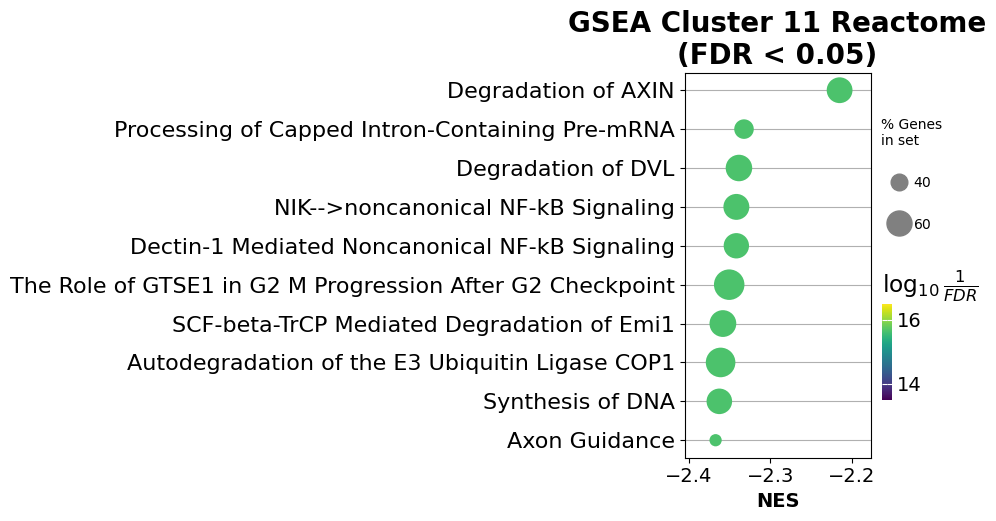

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, 
                           title="GSEA Cluster 11 Reactome\n(FDR < 0.05)", cutoff=0.05, fig_size=(3,5))

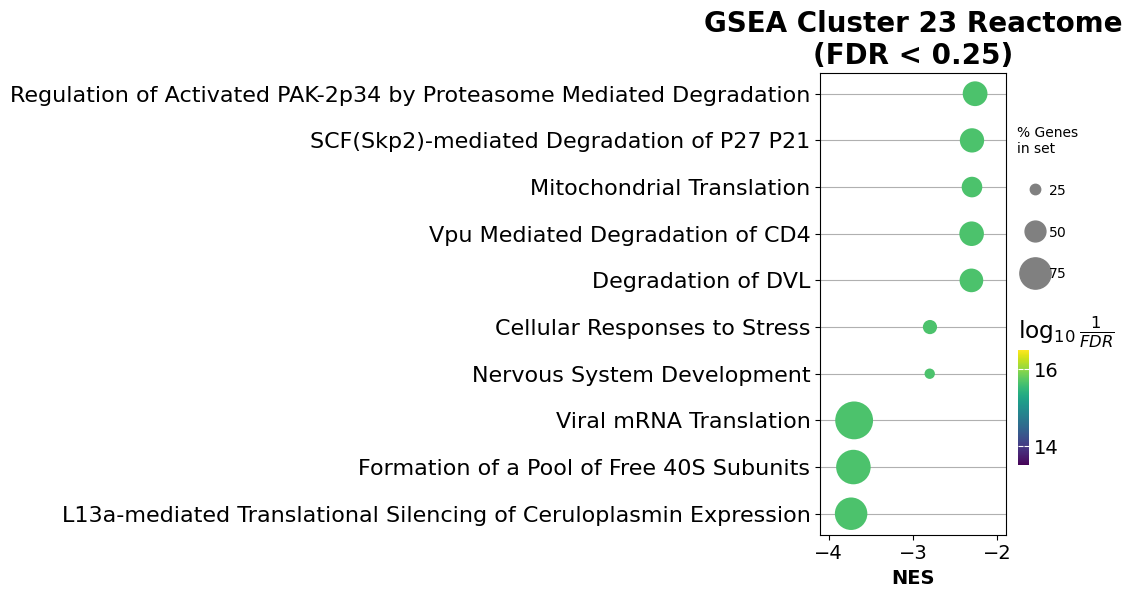

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, 
                           title="GSEA Cluster 23 Reactome\n(FDR < 0.25)", fig_size=(3, 6))

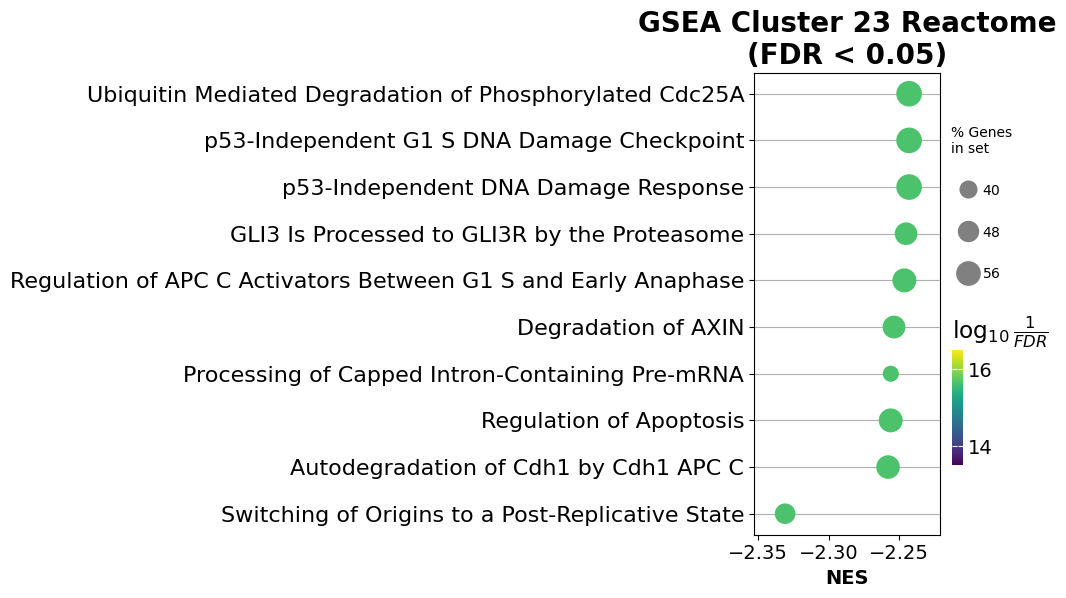

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, 
                           title="GSEA Cluster 23 Reactome\n(FDR < 0.05)", cutoff=0.05, fig_size=(3,6))

Save all Reactome dotplots with FDR < 0.05

In [ ]:
def plot_all_dotplots(prerank_results_dict, gene_set_lib, folder, gene_set_lib_abbrev):
    clusters = list(prerank_results_dict.keys())
    for i in tqdm(range(len(clusters)), desc="Processing cluster number"):
        cluster = clusters[i]
        title=f"GSEA Cluster {cluster} {gene_set_lib}\n(FDR < 0.05)"
        output_file_name = f"{folder}/gseapy_dotplot_{gene_set_lib_abbrev}_CL{cluster}.png"
        dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num=cluster,
                                   title=title, fig_size=(3,6), cutoff=0.05, 
                                   output_filename=output_file_name)

In [ ]:
gseapy_reac_folder = "/home/ranwyl/results_tf_project/gseapy_reac_figs"
plot_all_dotplots(prerank_res_reac8, "Reactome", gseapy_reac_folder, "reac")

Processing cluster number: 100%|██████████| 29/29 [00:19<00:00,  1.51it/s]


### MSigDB Hallmark

In [7]:
prerank_res_hallmark8 = prerank_gsea(clusters_8nbrs, de_results, "MSigDB_Hallmark_2020")

Processing cluster number:   0%|          | 0/28 [00:00<?, ?it/s]

Processing cluster number: 100%|██████████| 28/28 [00:38<00:00,  1.37s/it]


In [8]:
prerank_res_df_hallmark8 = build_prerank_gsea_results_df(prerank_res_hallmark8)

In [9]:
prerank_res_df_hallmark8.head(5)

Cluster                       Term        ES       NES NOM p-val FDR q-val  \
0        0             Myc Targets V1 -0.784574 -2.999088       0.0       0.0   
1        0  Oxidative Phosphorylation -0.725112 -2.768131       0.0       0.0   
2        0             UV Response Dn  0.509999  2.282448       0.0       0.0   
3        0           mTORC1 Signaling -0.573514 -2.161906       0.0       0.0   
4        0  Unfolded Protein Response -0.601105 -2.133628       0.0       0.0   

  FWER p-val    Tag %  Gene %  \
0        0.0  137/199  12.92%   
1        0.0  107/196  12.70%   
2        0.0   59/128  20.03%   
3        0.0   83/188  18.60%   
4        0.0   46/109  18.59%   

                                          Lead_genes  
0  RPS10;H2AZ1;RPS2;RPS3;RPS6;NPM1;RAN;RPLP0;RPS5...  
1  ATP5MC3;UQCRH;SLC25A6;COX7C;PRDX3;NDUFA4;SLC25...  
2  MAGI2;ADGRL2;PLCB4;IGF1R;CDC42BPA;BCKDHB;MMP16...  
3  PRDX1;PPIA;GAPDH;HSPE1;PSMA3;LDHA;HSPD1;ENO1;S...  
4  RPS14;NPM1;EIF4A1;CKS1B;LSM4;SEC11A;PDIA6;BANF...

In [19]:
prerank_res_df_hallmark8.head(20)

Cluster                             Term        ES       NES NOM p-val  \
0         0                   Myc Targets V1 -0.792242 -3.072981       0.0   
1         0        Oxidative Phosphorylation -0.709394 -2.751148       0.0   
2         0                   Myc Targets V2 -0.699512 -2.263479       0.0   
3         0  Reactive Oxygen Species Pathway -0.703148 -2.186322       0.0   
4         0                 mTORC1 Signaling -0.550922 -2.123002       0.0   
5         0        Unfolded Protein Response -0.576021 -2.091708       0.0   
6         0                      E2F Targets -0.509788 -1.973109       0.0   
7         0                       DNA Repair -0.514795 -1.936719       0.0   
8         0              Allograft Rejection -0.523857 -1.838335  0.001215   
9         0            Fatty Acid Metabolism -0.486733 -1.803316  0.001188   
10        0                   UV Response Dn   0.39297   1.79914       0.0   
11        0            Xenobiotic Metabolism -0.483688 -1.778073  0.002404   
12        0                     Adipogenesis -0.468398 -1.767991       0.0   
13        0                  G2-M Checkpoint -0.436136 -1.674799  0.001086   
14        0                   UV Response Up -0.452452 -1.669771       0.0   
15        0                      Pperoxisome -0.479024 -1.668865       0.0   
16        0                       Glycolysis -0.421474 -1.596493       0.0   
17        0              Pancreas Beta Cells -0.591999 -1.545148  0.047976   
18        0                  Mitotic Spindle  0.319693  1.527909       0.0   
19        0                KRAS Signaling Dn  0.345721  1.475533  0.005025   

   FDR q-val FWER p-val    Tag %  Gene %  \
0        0.0        0.0  129/199  12.30%   
1        0.0        0.0  111/196  13.92%   
2        0.0        0.0    36/55  22.07%   
3        0.0        0.0    18/42   9.51%   
4        0.0        0.0   99/188  24.94%   
5        0.0        0.0   53/109  23.27%   
6   0.000142      0.001   79/198  19.30%   
7   0.000248      0.002   54/142  16.91%   
8   0.000991      0.009    24/86  17.41%   
9   0.001585      0.016   51/117  22.09%   
10  0.009397      0.009   37/128  14.01%   
11  0.002252      0.025   50/121  24.73%   
12  0.002807      0.034   65/172  20.40%   
13  0.007241      0.088   50/193  11.34%   
14  0.007006      0.092   56/132  25.03%   
15  0.006539      0.092    27/82  20.87%   
16  0.012447      0.181   56/168  23.57%   
17  0.020807      0.291     5/17   8.25%   
18  0.054292        0.1   64/195  19.88%   
19  0.052204      0.134    19/76  17.77%   

                                           Lead_genes  
0   RPS6;RPS2;H2AZ1;RPL34;RPS10;EIF4A1;RPS3;RAN;NP...  
1   COX7C;ATP5MC3;UQCRH;CYCS;ATP5MG;NDUFA4;SLC25A3...  
2   NPM1;HSPE1;HSPD1;NDUFAF4;PA2G4;CBX3;UNG;NOLC1;...  
3   PRDX1;FTL;MGST1;TXN;PRDX2;SELENOS;GPX4;LAMTOR5...  
4   PRDX1;PPIA;HSPE1;HSPD1;CD9;PSMB5;TPI1;SEC11A;G...  
5   RPS14;EIF4A1;NPM1;CKS1B;PDIA6;SEC11A;YWHAZ;NHP...  
6   H2AZ1;RAN;RANBP1;STMN1;HMGA1;CKS2;SRSF2;CKS1B;...  
7   RBX1;COX17;POLR2K;IMPDH2;DUT;NME4;DGUOK;POLR2I...  
8   RPL39;RPS3A;NPM1;RPL9;RPS9;RPS19;EIF5A;NME1;TH...  
9   H2AZ1;MIF;HSP90AA1;LDHA;YWHAH;SDHC;OSTC;ENO2;E...  
10  BCKDHB;MAGI2;ATP2C1;MT1E;PTPRM;RUNX1;APBB2;AKT...  
11  PTGES3;DDT;ADH5;SPINT2;PGD;PGRMC1;TNFRSF1A;DDA...  
12  DDT;PRDX3;TALDO1;UQCRQ;SDHC;AIFM1;COX6A1;NDUFA...  
13  H2AZ1;STMN1;HMGA1;CKS2;SRSF2;CKS1B;HMGN2;SNRPD...  
14  PPIF;AP2S1;ENO2;POLR2H;SELENOW;ATP6V1F;SIGMAR1...  
15  PRDX1;YWHAH;CRABP1;PRDX5;CNBP;IDH2;SLC25A4;PAB...  
16  PPIA;STMN1;MIF;TXN;TPI1;LDHA;TALDO1;SDHC;PGAM1...  
17                      SRP14;SEC11A;SPCS1;SRPRB;SRP9  
18  MYH10;ITSN1;DST;SPTBN1;CENPE;FLNA;DYNC1H1;AKAP...  
19  GRID2;RYR2;BTG2;TENM2;THRB;CDKAL1;ACTC1;DTNB;P...

In [76]:
# Save
prerank_res_df_hallmark8.to_pickle("/home/ranwyl/results_tf_project/gsea_hallmark_mde_4265degs_padj_8nbrs.pkl")

In [84]:
prerank_res_df_hallmark8 = pd.read_pickle("/home/ranwyl/results_tf_project/gsea_hallmark_mde_4265degs_padj_8nbrs.pkl")
prerank_res_df_hallmark8.head()

Cluster                       Term        ES       NES NOM p-val FDR q-val  \
0        0             Myc Targets V1 -0.784574 -2.999088       0.0       0.0   
1        0  Oxidative Phosphorylation -0.725112 -2.768131       0.0       0.0   
2        0             UV Response Dn  0.509999  2.282448       0.0       0.0   
3        0           mTORC1 Signaling -0.573514 -2.161906       0.0       0.0   
4        0  Unfolded Protein Response -0.601105 -2.133628       0.0       0.0   

  FWER p-val    Tag %  Gene %  \
0        0.0  137/199  12.92%   
1        0.0  107/196  12.70%   
2        0.0   59/128  20.03%   
3        0.0   83/188  18.60%   
4        0.0   46/109  18.59%   

                                          Lead_genes  
0  RPS10;H2AZ1;RPS2;RPS3;RPS6;NPM1;RAN;RPLP0;RPS5...  
1  ATP5MC3;UQCRH;SLC25A6;COX7C;PRDX3;NDUFA4;SLC25...  
2  MAGI2;ADGRL2;PLCB4;IGF1R;CDC42BPA;BCKDHB;MMP16...  
3  PRDX1;PPIA;GAPDH;HSPE1;PSMA3;LDHA;HSPD1;ENO1;S...  
4  RPS14;NPM1;EIF4A1;CKS1B;LSM4;SEC11A;PDIA6;BANF...

In [78]:
top_term_hallmark8 = top_gsea_terms_from_prerank_dict(prerank_res_hallmark8, n_top_terms=1)

In [79]:
top_term_hallmark8.head()

Cluster            Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0        0  Myc Targets V1 -0.784574 -2.999088       0.0       0.0        0.0   
0        1  Myc Targets V1 -0.781031 -2.927445       0.0       0.0        0.0   
0        2  Myc Targets V1 -0.746425 -2.908199       0.0       0.0        0.0   
0        3  Myc Targets V1 -0.788639 -3.048009       0.0       0.0        0.0   
0        4  Myc Targets V1 -0.791584 -3.161018       0.0       0.0        0.0   

     Tag %  Gene %                                         Lead_genes  
0  137/199  12.92%  RPS10;H2AZ1;RPS2;RPS3;RPS6;NPM1;RAN;RPLP0;RPS5...  
0  130/199  12.28%  RPS3;RPS10;RPS2;H2AZ1;RPS6;EIF4A1;RPL18;RPL14;...  
0  110/199  10.83%  RPL34;RPS2;RPS10;RPS6;PPIA;SET;RPL14;RPS5;H2AZ...  
0  140/199  13.83%  RPS2;RAN;H2AZ1;RPS10;EIF4A1;HSP90AB1;NPM1;RPS6...  
0  132/199  10.90%  SET;NPM1;HSP90AB1;RAN;RPS2;RPS3;EIF4A1;RPS6;HS...

In [85]:
top_5_terms_hallmark8 = top_gsea_terms_from_prerank_dict(prerank_res_hallmark8, n_top_terms=5)

In [86]:
top_10_terms_hallmark8 = top_gsea_terms_from_prerank_df(prerank_res_df_hallmark8, 10)

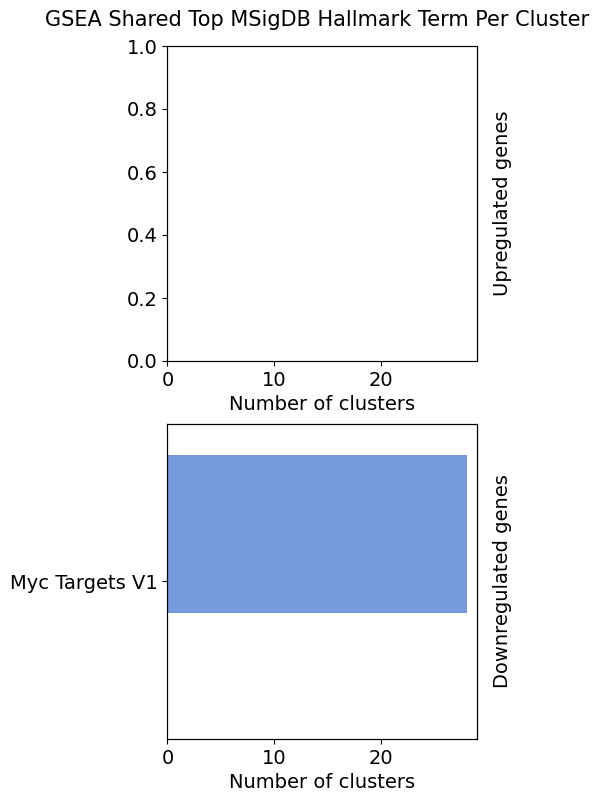

In [106]:
_ = plot_shared_top_terms_prerank_gsea(top_term_hallmark8, 
"GSEA Shared Top MSigDB Hallmark Term Per Cluster")

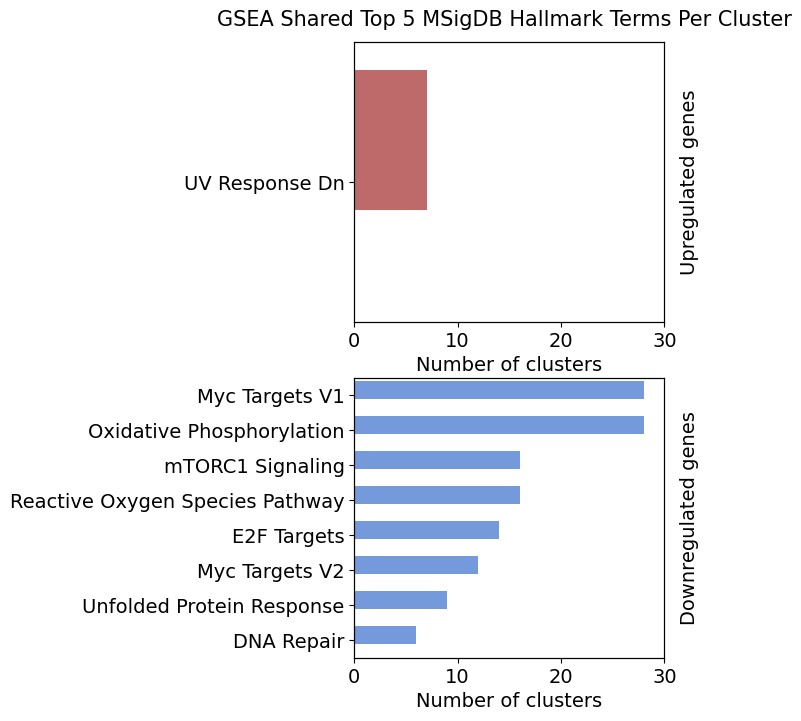

In [144]:
term_list5, up_df5, down_df5 = plot_shared_top_terms_prerank_gsea(top_5_terms_hallmark8, 
"GSEA Shared Top 5 MSigDB Hallmark Terms Per Cluster", xmax=30, min_clusters=2, fig_size=(4,8))

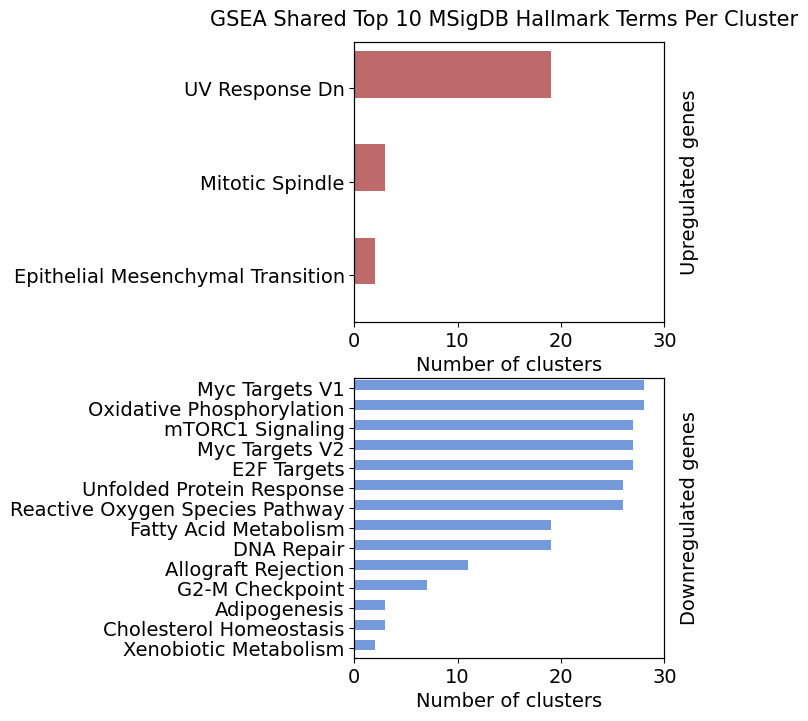

In [143]:
term_list10, _, _ = plot_shared_top_terms_prerank_gsea(top_10_terms_hallmark8, 
"GSEA Shared Top 10 MSigDB Hallmark Terms Per Cluster", xmax=30, min_clusters=2, fig_size=(4,8))

In [153]:
pd.set_option('display.max_rows', None)
top_terms = prerank_res_df_hallmark8.groupby("Cluster").head(25)[["Cluster", "Term", "NES", "FDR q-val"]]
top_terms = top_terms[top_terms["FDR q-val"] < 0.05]
top_term_counts = pd.DataFrame(top_terms["Term"].value_counts())
top_term_counts_unique = top_term_counts[top_term_counts["count"] < 7]
unique_term_list = top_term_counts_unique.index.tolist()
top_terms[top_terms["Term"].isin(unique_term_list)]

Cluster                               Term       NES FDR q-val
19        0          Interferon Alpha Response -1.466833  0.046027
20        3          Interferon Alpha Response -1.499172  0.030093
22        3                        p53 Pathway -1.457018  0.041633
4         4  Epithelial Mesenchymal Transition  2.322531       0.0
13        4              Inflammatory Response  1.866857  0.003152
15        4                 TGF-beta Signaling  1.672913   0.01559
18        6                        p53 Pathway  -1.57571  0.016581
19        8                 TGF-beta Signaling -1.449259  0.046741
20        9          Interferon Alpha Response -1.502023   0.03221
23        9  Epithelial Mesenchymal Transition  1.397507  0.049125
24        9                       Angiogenesis  1.375771  0.048542
19       10          Interferon Alpha Response -1.459183   0.04891
15       11                     Apical Surface  1.622979  0.015501
19       11                        p53 Pathway -1.538815  0.023417
14       16                       Angiogenesis  1.573937  0.035067
13       17          Interferon Alpha Response -1.529557  0.035518
17       18                        p53 Pathway  -1.49573  0.041475
12       19                         Myogenesis  1.619559  0.037034
14       19  Epithelial Mesenchymal Transition  1.589677   0.03234
19       21                  Protein Secretion -1.447558  0.046132
9        22  Epithelial Mesenchymal Transition  1.664854  0.025623
17       23                       Angiogenesis  1.518668  0.037535
18       24                        p53 Pathway -1.461754  0.049985
11       27                     Apical Surface  1.660436  0.039724
18       27             Estrogen Response Late -1.540575  0.020428
21       27                  Protein Secretion -1.444183    0.0454

In [154]:
pd.set_option('display.max_rows', None)
top_terms = prerank_res_df_hallmark8.groupby("Cluster").head(25)[["Cluster", "Term", "NES", "FDR q-val"]]
top_terms = top_terms[top_terms["FDR q-val"] < 0.05]
top_term_counts = pd.DataFrame(top_terms["Term"].value_counts())
top_term_counts_unique = top_term_counts[top_term_counts["count"] < 3]
unique_term_list = top_term_counts_unique.index.tolist()
top_terms[top_terms["Term"].isin(unique_term_list)]

Cluster                    Term       NES FDR q-val
13        4   Inflammatory Response  1.866857  0.003152
15        4      TGF-beta Signaling  1.672913   0.01559
19        8      TGF-beta Signaling -1.449259  0.046741
15       11          Apical Surface  1.622979  0.015501
12       19              Myogenesis  1.619559  0.037034
19       21       Protein Secretion -1.447558  0.046132
11       27          Apical Surface  1.660436  0.039724
18       27  Estrogen Response Late -1.540575  0.020428
21       27       Protein Secretion -1.444183    0.0454

In [155]:
pd.set_option('display.max_rows', None)
top_terms = prerank_res_df_hallmark8.groupby("Cluster").head(25)[["Cluster", "Term", "NES", "FDR q-val"]]
top_terms = top_terms[top_terms["FDR q-val"] < 0.05]
top_term_counts = pd.DataFrame(top_terms["Term"].value_counts())
top_term_counts_unique = top_term_counts[top_term_counts["count"] < 2]
unique_term_list = top_term_counts_unique.index.tolist()
top_terms[top_terms["Term"].isin(unique_term_list)]

Cluster                    Term       NES FDR q-val
13        4   Inflammatory Response  1.866857  0.003152
12       19              Myogenesis  1.619559  0.037034
18       27  Estrogen Response Late -1.540575  0.020428

Cluster 4

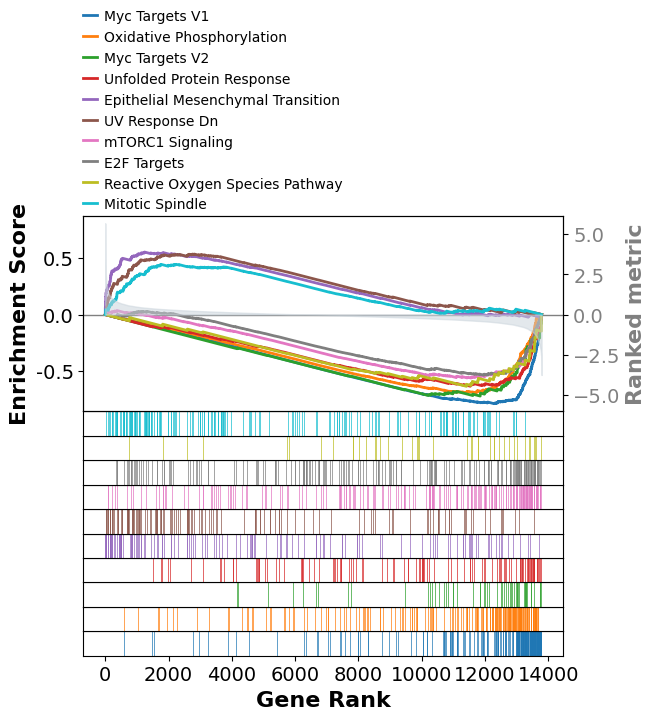

In [159]:
plot_terms_prerank_gsea(prerank_res_hallmark8, cluster_num=4, n_terms=10, title="")

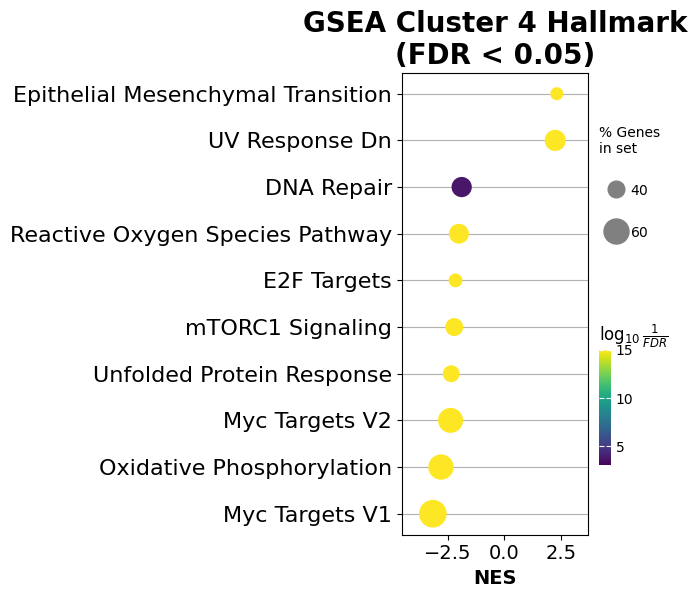

In [14]:
dotplot_terms_prerank_gsea(prerank_res_hallmark8, cluster_num=4, cutoff=0.05, fig_size=(3,6),
                           title="GSEA Cluster 4 Hallmark\n(FDR < 0.05)")

In [15]:
prerank_res_df_hallmark8.head()

Cluster                       Term        ES       NES NOM p-val FDR q-val  \
0        0             Myc Targets V1 -0.784574 -2.999088       0.0       0.0   
1        0  Oxidative Phosphorylation -0.725112 -2.768131       0.0       0.0   
2        0             UV Response Dn  0.509999  2.282448       0.0       0.0   
3        0           mTORC1 Signaling -0.573514 -2.161906       0.0       0.0   
4        0  Unfolded Protein Response -0.601105 -2.133628       0.0       0.0   

  FWER p-val    Tag %  Gene %  \
0        0.0  137/199  12.92%   
1        0.0  107/196  12.70%   
2        0.0   59/128  20.03%   
3        0.0   83/188  18.60%   
4        0.0   46/109  18.59%   

                                          Lead_genes  
0  RPS10;H2AZ1;RPS2;RPS3;RPS6;NPM1;RAN;RPLP0;RPS5...  
1  ATP5MC3;UQCRH;SLC25A6;COX7C;PRDX3;NDUFA4;SLC25...  
2  MAGI2;ADGRL2;PLCB4;IGF1R;CDC42BPA;BCKDHB;MMP16...  
3  PRDX1;PPIA;GAPDH;HSPE1;PSMA3;LDHA;HSPD1;ENO1;S...  
4  RPS14;NPM1;EIF4A1;CKS1B;LSM4;SEC11A;PDIA6;BANF...

In [1]:
def cluster_top10_terms(prerank_res_df, cluster_num, fdr_cutoff):
    """
    Return DataFrame of top 10 enriched terms for cluster cluster_num 
    with greatest absolute NES and FDR < fdr_cutoff.
    """
    top10_term_df = prerank_res_df[(prerank_res_df["Cluster"] == cluster_num) & 
                          (prerank_res_df["FDR q-val"] < fdr_cutoff)].copy()
    top10_term_df.sort_values(by="NES", key=abs, ascending=False, inplace=True)
    top10_term_df = top10_term_df.head(10)
    return top10_term_df

In [2]:
cl4_top10_df = cluster_top10_terms(prerank_res_df_hallmark8, 4, 0.05)
display(cl4_top10_df)

NameError: name 'prerank_res_df_hallmark8' is not defined

In [ ]:
def build_lead_genes_dict(top10_term_df)

All dotplots

Save all Hallmark dotplots with FDR < 0.05

In [ ]:
def plot_all_dotplots(prerank_results_dict, gene_set_lib, folder, gene_set_lib_abbrev):
    clusters = list(prerank_results_dict.keys())
    for i in tqdm(range(len(clusters)), desc="Processing cluster number"):
        cluster = clusters[i]
        title=f"GSEA Cluster {cluster} {gene_set_lib}\n(FDR < 0.05)"
        output_file_name = f"{folder}/gseapy_dotplot_{gene_set_lib_abbrev}_CL{cluster}.png"
        dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num=cluster,
                                   title=title, fig_size=(3,6), cutoff=0.05, 
                                   output_filename=output_file_name)

In [78]:
gseapy_hallmark_folder = "/home/ranwyl/results_tf_project/gseapy_hallmark_figs"
plot_all_dotplots(prerank_res_hallmark8, "Hallmark", gseapy_hallmark_folder, "hallmark")

Processing cluster number: 100%|██████████| 29/29 [00:14<00:00,  1.98it/s]
